# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


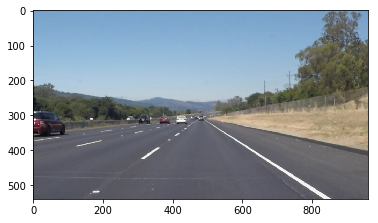

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [71]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(line):
    x1,y1,x2,y2 = line
    return ((y2-y1)/(x2-x1))

def ordered_line(line):
    if(line[1]<line[3]):
        return line
    else: 
        return [line[2],line[3],line[0],line[1]]

def complete_line(y,α,point):
    #complete the line to a point with the expected y value
    #y=α*x+β
    point_x=point[0]
    point_y=point[1]
    β=point_y-α*point_x
    x=int((y-β)/α)
    return [point_x,point_y,x,y]    
    
def extrapolate_line(lines, midle=325, height=540):
    #sort lines by the minimum y value
    sorted_lines = sorted(lines, key = lambda line: min(line[1],line[3]))
    result = list(sorted_lines)
    size=len(sorted_lines)
    for idx in range(0,size-2):
        first = ordered_line(sorted_lines[idx])
        second = ordered_line(sorted_lines[idx+1])
        result.append((first[2],first[3],second[0],second[1]))
    if size >0:        
        first_line = ordered_line(sorted_lines[0])
        result.append(complete_line(midle,slope(first_line), first_line[0:2]))
        last_line = ordered_line(sorted_lines[size-1])
        result.append(complete_line(height,slope(last_line),last_line[2:4]))  
    return result
    
def extrapolate_lines(lines):    
    flattened=[segment for line in lines for segment in line]
    left_lines = [line for line in flattened if slope(line) <0]
    right_lines = [line for line in flattened if slope(line) >0]
    return [extrapolate_line(left_lines) , extrapolate_line(right_lines)]

def draw_lines(img, lines, color=[255, 0, 0], thickness=2, extrapolate=False):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if extrapolate:
        lines = extrapolate_lines(lines)
        print(lines)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, extrapolate=extrapolate)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
test_images = "test_images/"
os.listdir(test_images)

['solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
def display_image(img, title):
    plt.figure()
    plt.title(title)
    plt.imshow(img)
    directory = "test_images_output/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig("{}{}.jpg".format(directory, title))

In [72]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def draw_lane_lines(img, display=False, name="", extrapolate=False):
    #gray scale
    img_gray = grayscale(img)
    
    #gaussian smooth
    kernel_size = 5
    img_gray_blur = gaussian_blur(img_gray, kernel_size)
    
    #edge detection
    low_threshold = 50
    high_threshold = 150
    edges = canny(img_gray_blur, low_threshold, high_threshold)
    
    #delimiting the zone of interest
    height,width = img.shape[0], img.shape[1]
    vertices = np.array([[(0,height),(width *.50, height*.58), (width *.52, height*.59), (width,height)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    #Draw the lines on the masked edges
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, extrapolate)
    
    #Supperpose the lines to the original image
    img_lane_lines = weighted_img(line_img, img)
    
    if display:        
        display_image(img, name)
        display_image(img_gray, name+"-gray")
        display_image(edges, name+"-edges")
        display_image(masked_edges, name+"-masked_edges")
        display_image(line_img, name+"-line_img")
        display_image(img_lane_lines, name+"-lane_lines")
    
    return img_lane_lines
    

[[[627 404 832 538]]

 [[502 319 854 538]]

 [[493 316 772 498]]

 [[318 425 363 394]]

 [[387 371 460 322]]

 [[310 422 359 392]]

 [[524 333 853 539]]

 [[392 369 465 320]]

 [[319 425 362 395]]

 [[788 510 830 537]]

 [[391 372 438 340]]

 [[310 425 355 392]]]
[[[176 538 357 402]]

 [[487 315 550 352]]

 [[195 538 479 316]]

 [[501 319 607 381]]

 [[752 465 884 538]]

 [[389 381 477 315]]

 [[772 485 863 538]]

 [[330 424 374 390]]

 [[497 319 564 360]]

 [[423 361 481 316]]

 [[303 444 364 397]]

 [[506 323 591 376]]

 [[426 353 472 317]]

 [[241 490 284 487]]

 [[195 539 242 503]]

 [[511 326 607 382]]

 [[175 538 238 493]]

 [[262 487 315 443]]]
[[[231 497 442 338]]

 [[362 394 440 335]]

 [[175 539 246 484]]

 [[258 466 321 421]]

 [[612 391 658 417]]

 [[155 538 254 467]]

 [[606 392 648 419]]

 [[479 316 584 372]]

 [[292 452 438 342]]

 [[486 316 580 374]]

 [[488 316 582 374]]

 [[218 494 260 463]]

 [[493 324 559 362]]

 [[175 538 241 488]]

 [[527 339 583 373]]

 [[363 392

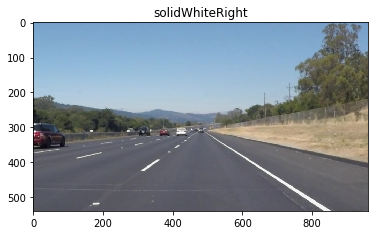

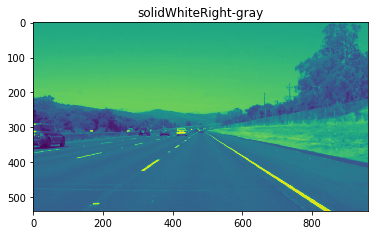

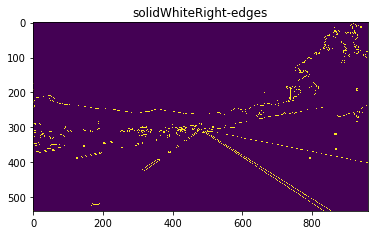

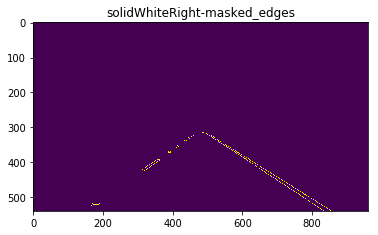

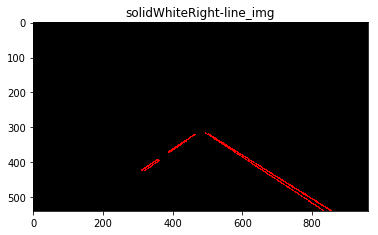

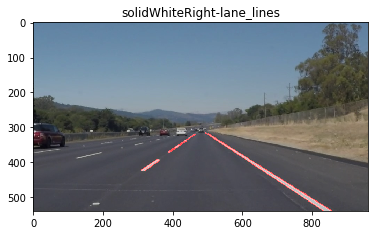

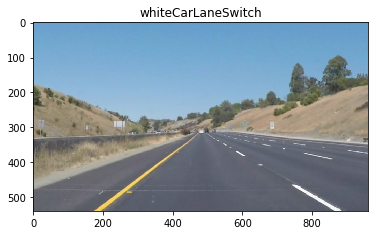

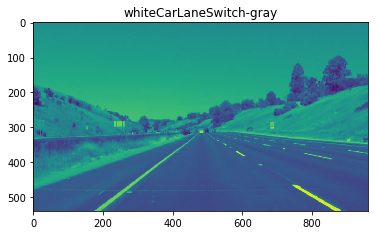

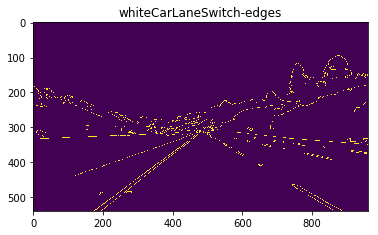

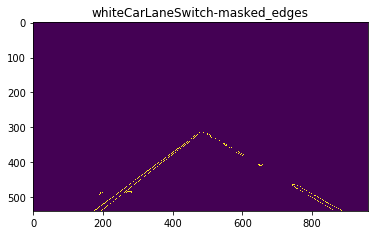

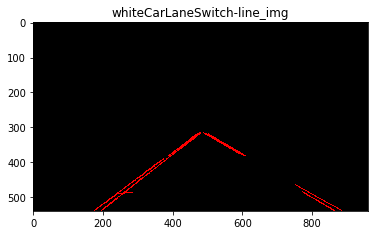

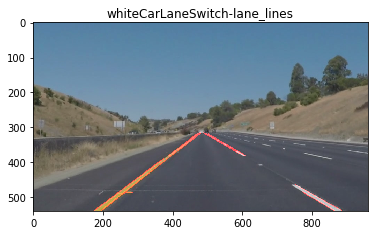

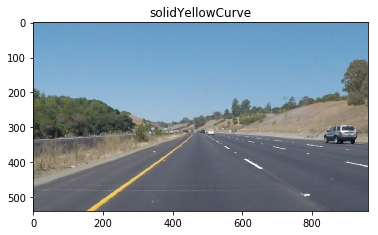

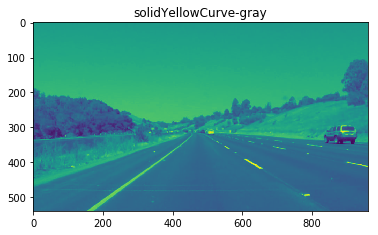

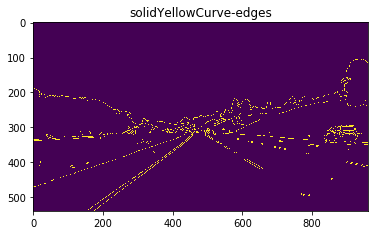

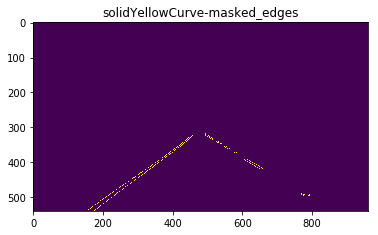

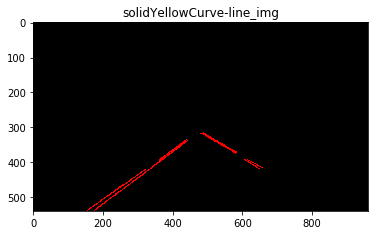

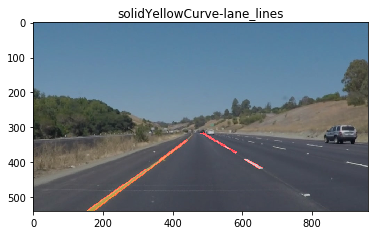

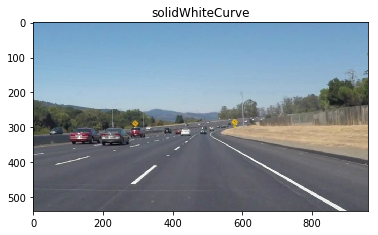

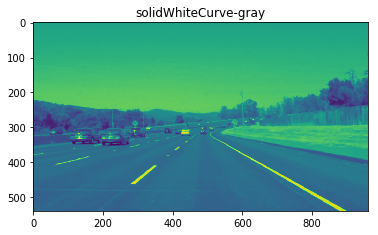

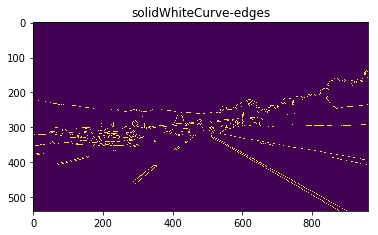

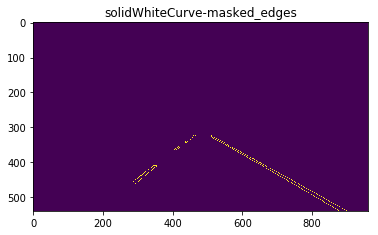

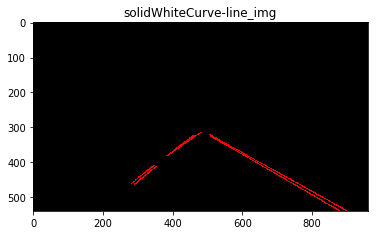

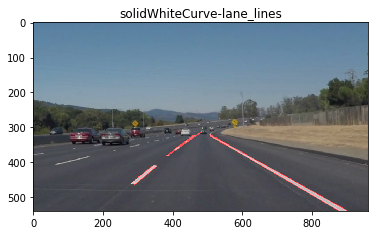

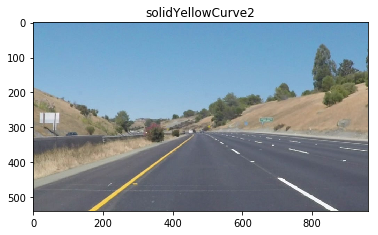

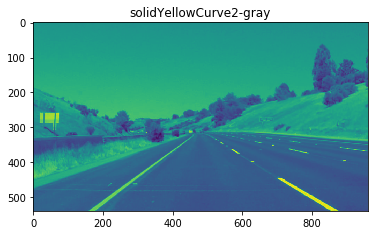

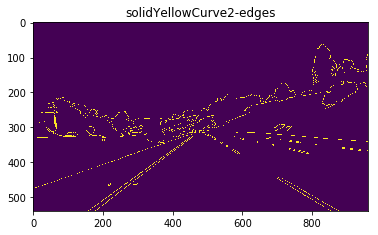

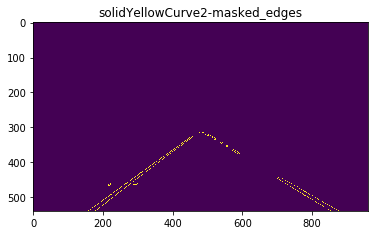

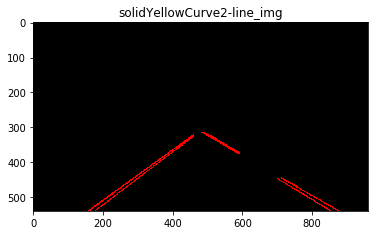

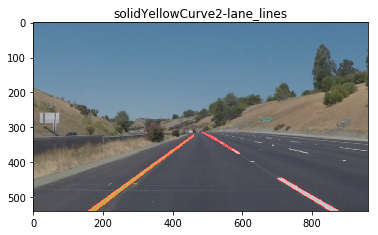

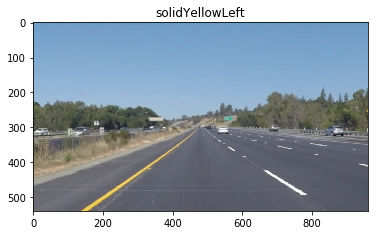

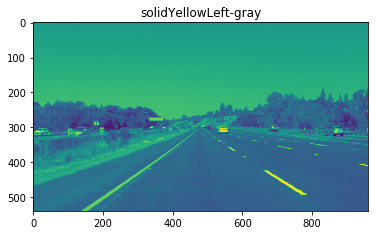

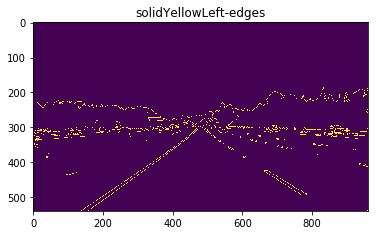

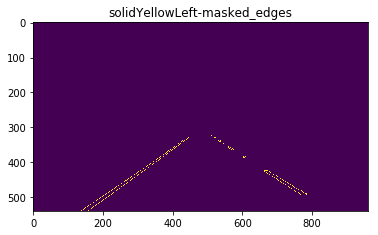

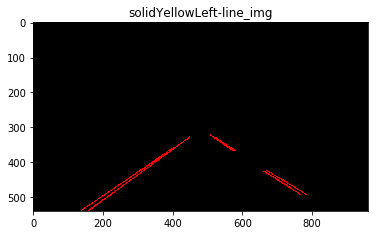

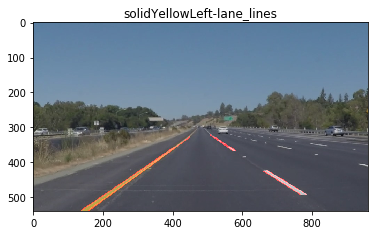

In [47]:
for img_src in os.listdir(test_images):
    img = mpimg.imread(test_images+img_src)
    draw_lane_lines(img,True,img_src[:-4])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return draw_lane_lines(image)

In [31]:
#make sure that test_videos_output dir exists
test_videos_output = "test_videos_output/"
if not os.path.exists(test_videos_output):
    os.makedirs(test_videos_output)

Let's try the one with the solid white lane on the right first ...

In [32]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 12.1 s, sys: 72 ms, total: 12.1 s
Wall time: 6.42 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

[[array([392, 369, 465, 320], dtype=int32), array([387, 371, 460, 322], dtype=int32), array([391, 372, 438, 340], dtype=int32), array([310, 422, 359, 392], dtype=int32), array([310, 425, 355, 392], dtype=int32), array([318, 425, 363, 394], dtype=int32), array([319, 425, 362, 395], dtype=int32), (392, 369, 460, 322), (387, 371, 438, 340), (391, 372, 359, 392), (310, 422, 355, 392), (310, 425, 363, 394), [465, 320, 457, 325], [319, 425, 154, 540]], [array([493, 316, 772, 498], dtype=int32), array([502, 319, 854, 538], dtype=int32), array([524, 333, 853, 539], dtype=int32), array([627, 404, 832, 538], dtype=int32), array([788, 510, 830, 537], dtype=int32), (772, 498, 502, 319), (854, 538, 524, 333), (853, 539, 627, 404), [493, 316, 506, 325], [830, 537, 834, 540]]]
[[array([389, 381, 477, 315], dtype=int32), array([195, 538, 479, 316], dtype=int32), array([423, 361, 481, 316], dtype=int32), array([426, 353, 472, 317], dtype=int32), array([330, 424, 374, 390], dtype=int32), array([303, 444

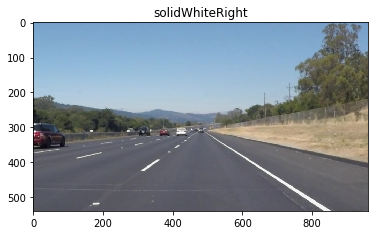

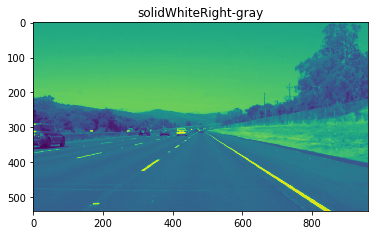

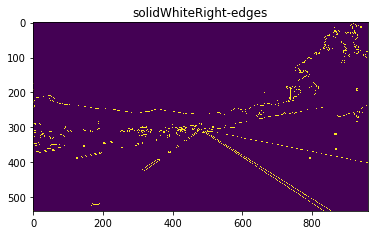

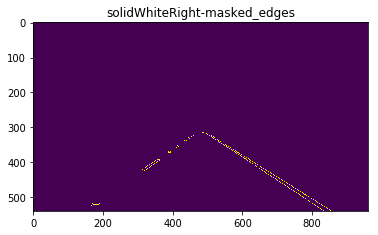

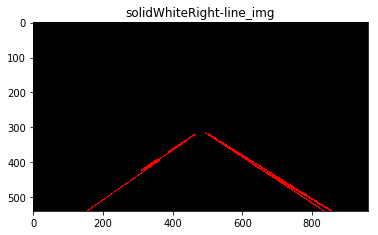

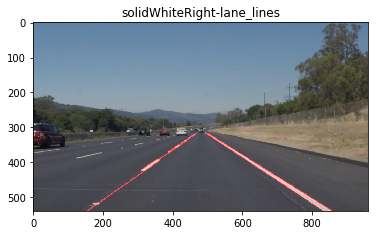

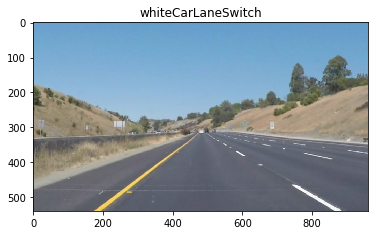

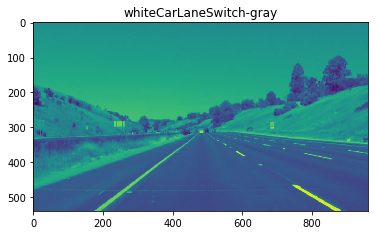

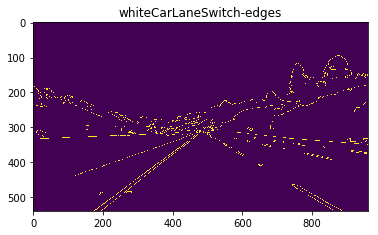

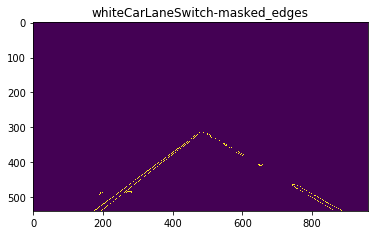

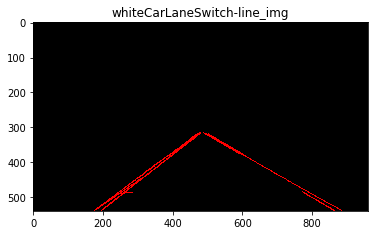

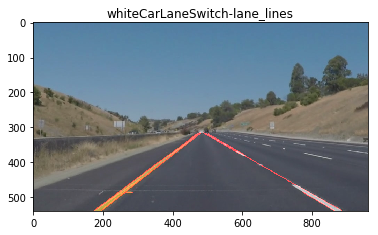

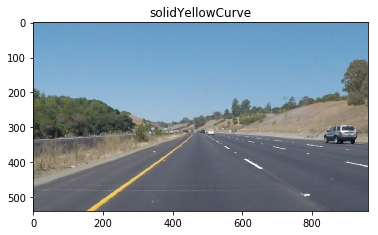

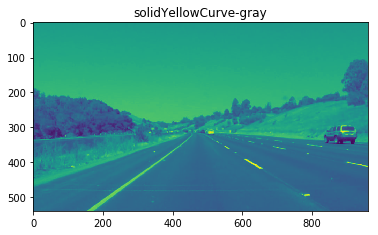

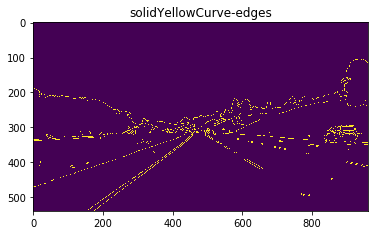

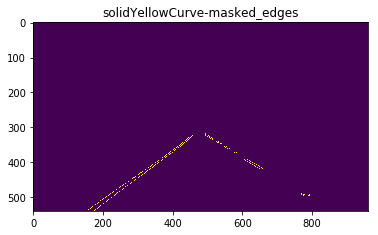

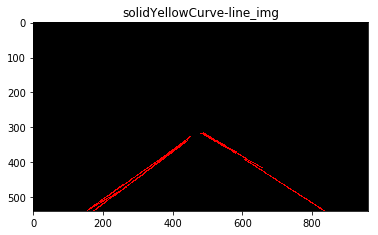

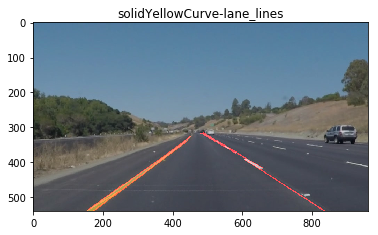

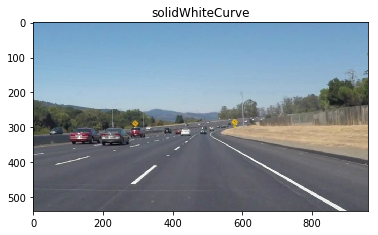

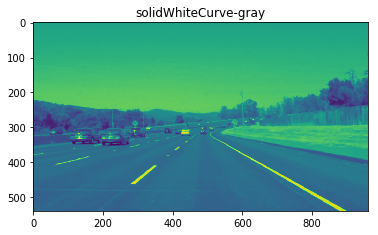

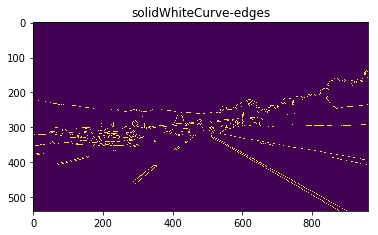

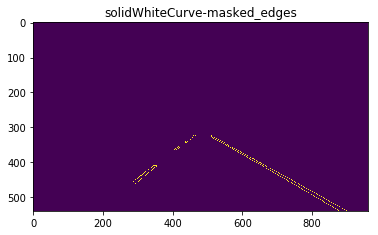

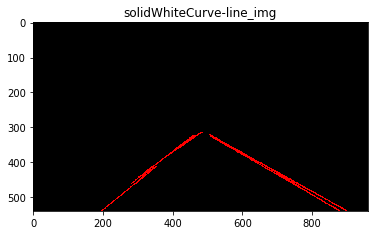

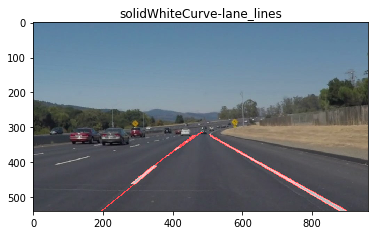

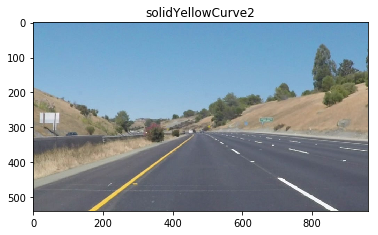

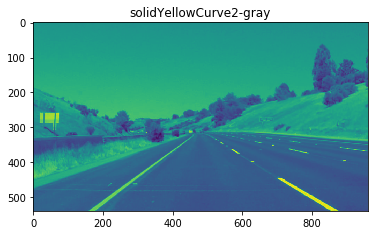

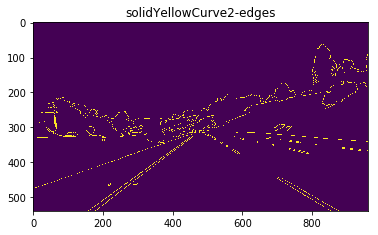

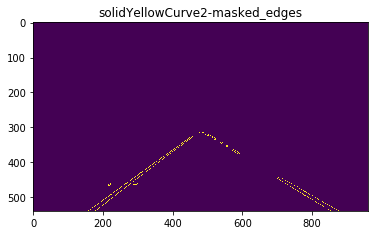

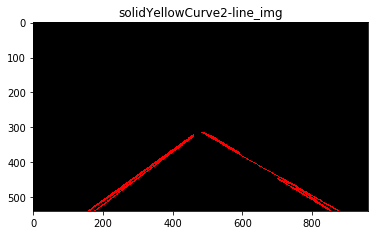

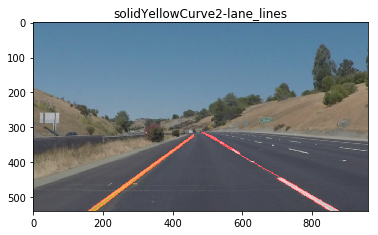

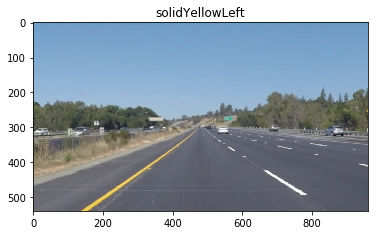

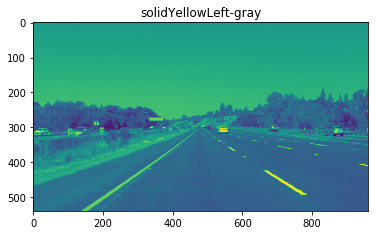

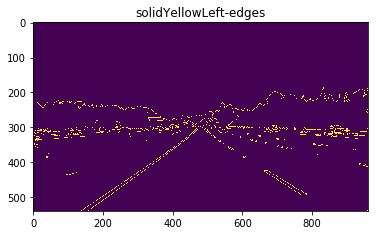

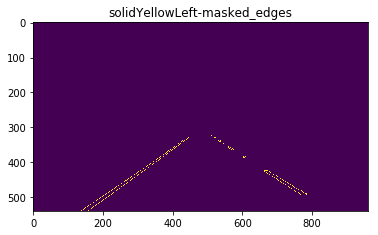

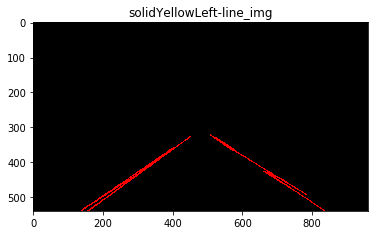

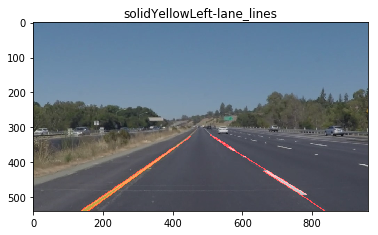

In [68]:
for img_src in os.listdir(test_images):
    img = mpimg.imread(test_images+img_src)
    draw_lane_lines(img,True,img_src[:-4],True)

In [73]:
def process_image_extrapolate(image):
    return draw_lane_lines(image, extrapolate=True)

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [74]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_extrapolate)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[array([420, 346, 460, 322], dtype=int32), array([414, 357, 456, 326], dtype=int32), array([411, 352, 455, 327], dtype=int32), array([250, 458, 444, 336], dtype=int32), array([112, 533, 422, 346], dtype=int32), array([105, 538, 316, 411], dtype=int32), array([247, 460, 304, 425], dtype=int32), array([214, 481, 271, 446], dtype=int32), array([124, 538, 268, 448], dtype=int32), (420, 346, 456, 326), (414, 357, 455, 327), (411, 352, 444, 336), (250, 458, 422, 346), (112, 533, 316, 411), (105, 538, 304, 425), (247, 460, 271, 446), [460, 322, 455, 325], [124, 538, 120, 540]], [array([523, 330, 563, 360], dtype=int32), array([538, 338, 579, 366], dtype=int32), array([537, 338, 577, 369], dtype=int32), array([541, 339, 581, 366], dtype=int32), array([664, 425, 775, 497], dtype=int32), array([658, 427, 758, 497], dtype=int32), array([669, 427, 727, 464], dtype=int32), array([692, 450, 744, 487], dtype=int32), array([724, 463, 766, 489], dtype=int32), (563, 360, 538, 338), (579, 366, 537, 338)


  1%|          | 4/682 [00:00<00:18, 36.14it/s]

[[array([420, 346, 460, 322], dtype=int32), array([414, 357, 456, 326], dtype=int32), array([411, 352, 455, 327], dtype=int32), array([250, 458, 444, 336], dtype=int32), array([112, 533, 422, 346], dtype=int32), array([105, 538, 316, 411], dtype=int32), array([247, 460, 304, 425], dtype=int32), array([214, 481, 271, 446], dtype=int32), array([124, 538, 268, 448], dtype=int32), (420, 346, 456, 326), (414, 357, 455, 327), (411, 352, 444, 336), (250, 458, 422, 346), (112, 533, 316, 411), (105, 538, 304, 425), (247, 460, 271, 446), [460, 322, 455, 325], [124, 538, 120, 540]], [array([523, 330, 563, 360], dtype=int32), array([538, 338, 579, 366], dtype=int32), array([537, 338, 577, 369], dtype=int32), array([541, 339, 581, 366], dtype=int32), array([664, 425, 775, 497], dtype=int32), array([658, 427, 758, 497], dtype=int32), array([669, 427, 727, 464], dtype=int32), array([692, 450, 744, 487], dtype=int32), array([724, 463, 766, 489], dtype=int32), (563, 360, 538, 338), (579, 366, 537, 338)


[[array([400, 361, 455, 326], dtype=int32), array([174, 515, 399, 368], dtype=int32), array([333, 404, 389, 370], dtype=int32), array([120, 539, 386, 372], dtype=int32), array([140, 538, 307, 429], dtype=int32), array([197, 489, 269, 445], dtype=int32), array([140, 539, 199, 500], dtype=int32), array([120, 538, 178, 501], dtype=int32), (400, 361, 399, 368), (174, 515, 389, 370), (333, 404, 386, 372), (120, 539, 307, 429), (140, 538, 269, 445), (197, 489, 199, 500), [455, 326, 456, 325], [120, 538, 116, 540]], [array([531, 333, 581, 365], dtype=int32), array([530, 334, 575, 364], dtype=int32), array([529, 335, 574, 366], dtype=int32), array([530, 335, 578, 367], dtype=int32), (581, 365, 530, 334), (575, 364, 529, 335), [531, 333, 518, 325], [578, 367, 837, 540]]]


  2%|▏         | 12/682 [00:00<00:19, 34.88it/s]


[[array([366, 389, 453, 328], dtype=int32), array([406, 358, 446, 329], dtype=int32), array([395, 364, 452, 329], dtype=int32), array([301, 433, 439, 340], dtype=int32), array([348, 395, 390, 369], dtype=int32), array([121, 538, 364, 386], dtype=int32), array([178, 514, 314, 423], dtype=int32), array([250, 457, 290, 431], dtype=int32), array([141, 539, 215, 488], dtype=int32), array([120, 538, 167, 508], dtype=int32), (366, 389, 446, 329), (406, 358, 452, 329), (395, 364, 439, 340), (301, 433, 390, 369), (348, 395, 364, 386), (121, 538, 314, 423), (178, 514, 290, 431), (250, 457, 215, 488), [453, 328, 457, 325], [120, 538, 116, 540]], [array([531, 333, 582, 369], dtype=int32), array([531, 336, 581, 369], dtype=int32), array([537, 336, 586, 369], dtype=int32), array([615, 387, 659, 414], dtype=int32), array([609, 387, 649, 416], dtype=int32), (582, 369, 531, 336), (581, 369, 537, 336), (586, 369, 615, 387), [531, 333, 519, 325], [649, 416, 820, 540]]]
[[array([399, 361, 451, 329], dtyp

[[array([217, 484, 452, 326], dtype=int32), array([266, 452, 450, 328], dtype=int32), array([354, 398, 430, 346], dtype=int32), array([256, 468, 426, 349], dtype=int32), array([251, 470, 333, 414], dtype=int32), array([238, 479, 278, 454], dtype=int32), array([147, 529, 204, 491], dtype=int32), array([152, 538, 217, 493], dtype=int32), (217, 484, 450, 328), (266, 452, 430, 346), (354, 398, 426, 349), (256, 468, 333, 414), (251, 470, 278, 454), (238, 479, 204, 491), [452, 326, 453, 325], [152, 538, 149, 540]], [array([528, 332, 601, 379], dtype=int32), array([540, 340, 598, 379], dtype=int32), array([544, 341, 602, 378], dtype=int32), array([745, 468, 850, 531], dtype=int32), array([734, 469, 795, 510], dtype=int32), array([758, 485, 825, 529], dtype=int32), array([787, 503, 839, 539], dtype=int32), array([815, 511, 861, 538], dtype=int32), (601, 379, 540, 340), (598, 379, 544, 341), (602, 378, 745, 468), (850, 531, 734, 469), (795, 510, 758, 485), (825, 529, 787, 503), [528, 332, 517, 


  3%|▎         | 21/682 [00:00<00:17, 37.89it/s]

[[array([201, 495, 452, 326], dtype=int32), array([392, 368, 443, 330], dtype=int32), array([180, 520, 437, 340], dtype=int32), array([234, 472, 297, 432], dtype=int32), array([153, 538, 248, 472], dtype=int32), array([214, 485, 263, 477], dtype=int32), array([170, 515, 211, 487], dtype=int32), array([133, 539, 188, 502], dtype=int32), array([133, 538, 180, 507], dtype=int32), (201, 495, 443, 330), (392, 368, 437, 340), (180, 520, 297, 432), (234, 472, 248, 472), (153, 538, 263, 477), (214, 485, 211, 487), (170, 515, 188, 502), [452, 326, 453, 325], [133, 538, 129, 540]], [array([526, 331, 610, 383], dtype=int32), array([527, 333, 583, 368], dtype=int32), array([544, 341, 598, 380], dtype=int32), array([545, 341, 609, 382], dtype=int32), array([548, 348, 605, 384], dtype=int32), array([791, 495, 861, 538], dtype=int32), array([775, 495, 839, 538], dtype=int32), (610, 383, 527, 333), (583, 368, 544, 341), (598, 380, 545, 341), (609, 382, 548, 348), (605, 384, 791, 495), [526, 331, 516, 

[[array([377, 376, 432, 341], dtype=int32), array([371, 380, 418, 352], dtype=int32), array([154, 538, 416, 354], dtype=int32), array([155, 538, 406, 362], dtype=int32), array([263, 452, 385, 372], dtype=int32), array([279, 443, 343, 399], dtype=int32), array([158, 523, 212, 486], dtype=int32), array([134, 538, 206, 490], dtype=int32), (377, 376, 418, 352), (371, 380, 416, 354), (154, 538, 406, 362), (155, 538, 385, 372), (263, 452, 343, 399), (279, 443, 212, 486), [432, 341, 457, 325], [134, 538, 131, 540]], [array([534, 336, 581, 364], dtype=int32), array([664, 416, 718, 447], dtype=int32), array([663, 416, 759, 472], dtype=int32), array([657, 418, 744, 474], dtype=int32), array([693, 440, 743, 473], dtype=int32), (581, 364, 664, 416), (718, 447, 663, 416), (759, 472, 657, 418), [534, 336, 515, 325], [743, 473, 844, 540]]]



  5%|▍         | 31/682 [00:00<00:16, 39.71it/s]

[[array([400, 361, 448, 328], dtype=int32), array([386, 378, 442, 333], dtype=int32), array([178, 512, 406, 358], dtype=int32), array([157, 538, 406, 363], dtype=int32), array([157, 539, 365, 393], dtype=int32), array([149, 531, 204, 493], dtype=int32), (400, 361, 442, 333), (386, 378, 406, 358), (178, 512, 406, 363), (157, 538, 365, 393), [448, 328, 452, 325], [149, 531, 135, 540]], [array([522, 329, 581, 370], dtype=int32), array([535, 336, 587, 368], dtype=int32), array([537, 336, 583, 370], dtype=int32), array([537, 340, 585, 370], dtype=int32), array([683, 428, 744, 465], dtype=int32), array([687, 429, 806, 503], dtype=int32), array([686, 429, 741, 464], dtype=int32), array([676, 431, 786, 502], dtype=int32), array([715, 455, 755, 481], dtype=int32), (581, 370, 535, 336), (587, 368, 537, 336), (583, 370, 537, 340), (585, 370, 683, 428), (744, 465, 687, 429), (806, 503, 686, 429), (741, 464, 676, 431), [522, 329, 516, 325], [755, 481, 845, 540]]]
[[array([391, 374, 444, 330], dtype


  5%|▌         | 36/682 [00:00<00:16, 39.46it/s]

[[array([388, 367, 439, 332], dtype=int32), array([366, 383, 433, 337], dtype=int32), array([337, 413, 419, 349], dtype=int32), array([198, 516, 413, 354], dtype=int32), array([146, 538, 386, 370], dtype=int32), array([173, 520, 353, 394], dtype=int32), array([173, 534, 264, 466], dtype=int32), (388, 367, 433, 337), (366, 383, 419, 349), (337, 413, 413, 354), (198, 516, 386, 370), (146, 538, 353, 394), [439, 332, 449, 325], [173, 534, 164, 540]], [array([631, 391, 690, 426], dtype=int32), array([635, 392, 690, 425], dtype=int32), array([626, 394, 680, 427], dtype=int32), array([632, 397, 682, 427], dtype=int32), (690, 426, 635, 392), (690, 425, 626, 394), [631, 391, 519, 325], [682, 427, 870, 540]]]
[[array([321, 417, 423, 340], dtype=int32), array([190, 522, 409, 357], dtype=int32), array([299, 431, 392, 365], dtype=int32), array([148, 537, 372, 380], dtype=int32), array([146, 539, 334, 407], dtype=int32), array([273, 461, 324, 422], dtype=int32), array([166, 539, 237, 486], dtype=int


  6%|▌         | 41/682 [00:01<00:15, 41.09it/s]

[[array([372, 382, 424, 342], dtype=int32), array([369, 378, 418, 342], dtype=int32), array([266, 453, 412, 347], dtype=int32), array([166, 538, 398, 363], dtype=int32), array([145, 538, 245, 468], dtype=int32), array([146, 537, 227, 479], dtype=int32), (372, 382, 418, 342), (369, 378, 412, 347), (266, 453, 398, 363), (166, 538, 245, 468), [424, 342, 446, 325], [146, 537, 141, 540]], [array([558, 347, 598, 369], dtype=int32), array([759, 466, 884, 538], dtype=int32), array([747, 467, 862, 539], dtype=int32), array([803, 492, 859, 524], dtype=int32), array([811, 506, 861, 538], dtype=int32), (598, 369, 759, 466), (884, 538, 747, 467), (862, 539, 803, 492), [558, 347, 518, 325], [861, 538, 864, 540]]]
[[array([335, 412, 389, 369], dtype=int32), array([165, 539, 389, 370], dtype=int32), array([145, 537, 378, 373], dtype=int32), array([144, 538, 351, 393], dtype=int32), array([164, 538, 262, 465], dtype=int32), array([231, 477, 276, 475], dtype=int32), (335, 412, 389, 370), (165, 539, 378,


  7%|▋         | 46/682 [00:01<00:16, 38.32it/s]

[[array([164, 539, 414, 350], dtype=int32), array([362, 383, 408, 350], dtype=int32), array([186, 523, 385, 373], dtype=int32), array([142, 538, 376, 374], dtype=int32), array([143, 539, 341, 400], dtype=int32), (164, 539, 408, 350), (362, 383, 385, 373), (186, 523, 376, 374), [414, 350, 447, 325], [143, 539, 141, 540]], [array([543, 339, 587, 366], dtype=int32), array([566, 350, 621, 383], dtype=int32), array([565, 351, 619, 382], dtype=int32), (587, 366, 566, 350), [543, 339, 520, 325], [619, 382, 894, 540]]]
[[array([377, 378, 433, 335], dtype=int32), array([234, 476, 417, 343], dtype=int32), array([363, 384, 416, 343], dtype=int32), array([348, 395, 410, 347], dtype=int32), array([186, 523, 402, 360], dtype=int32), array([329, 409, 385, 366], dtype=int32), array([199, 512, 311, 430], dtype=int32), array([207, 495, 253, 461], dtype=int32), array([143, 539, 189, 506], dtype=int32), (377, 378, 417, 343), (234, 476, 416, 343), (363, 384, 410, 347), (348, 395, 402, 360), (186, 523, 385,

[[array([348, 401, 439, 332], dtype=int32), array([189, 509, 424, 339], dtype=int32), array([356, 390, 417, 343], dtype=int32), array([326, 418, 369, 389], dtype=int32), array([276, 456, 345, 405], dtype=int32), array([267, 454, 317, 417], dtype=int32), array([199, 513, 311, 431], dtype=int32), array([173, 520, 248, 466], dtype=int32), (348, 401, 424, 339), (189, 509, 417, 343), (356, 390, 369, 389), (326, 418, 345, 405), (276, 456, 317, 417), (267, 454, 311, 431), [439, 332, 448, 325], [173, 520, 145, 540]], [array([535, 335, 594, 371], dtype=int32), array([543, 339, 592, 372], dtype=int32), array([634, 395, 699, 434], dtype=int32), array([636, 395, 700, 433], dtype=int32), array([633, 399, 689, 435], dtype=int32), (594, 371, 543, 339), (592, 372, 634, 395), (699, 434, 636, 395), [535, 335, 518, 325], [689, 435, 852, 540]]]
[[array([165, 539, 413, 352], dtype=int32), array([334, 411, 403, 359], dtype=int32), array([321, 413, 372, 378], dtype=int32), array([145, 538, 319, 416], dtype=i


  8%|▊         | 54/682 [00:01<00:18, 34.60it/s]

[[array([307, 431, 437, 333], dtype=int32), array([387, 370, 433, 335], dtype=int32), array([363, 384, 420, 341], dtype=int32), array([373, 376, 413, 345], dtype=int32), array([350, 393, 397, 357], dtype=int32), array([165, 539, 389, 370], dtype=int32), array([144, 538, 356, 389], dtype=int32), array([190, 507, 323, 411], dtype=int32), array([199, 514, 317, 425], dtype=int32), (307, 431, 433, 335), (387, 370, 420, 341), (363, 384, 413, 345), (373, 376, 397, 357), (350, 393, 389, 370), (165, 539, 356, 389), (144, 538, 323, 411), [437, 333, 447, 325], [199, 514, 164, 540]], [array([531, 334, 579, 361], dtype=int32), array([539, 337, 579, 360], dtype=int32), array([664, 411, 761, 469], dtype=int32), array([662, 411, 762, 471], dtype=int32), array([654, 412, 750, 471], dtype=int32), array([656, 414, 748, 471], dtype=int32), (579, 361, 539, 337), (579, 360, 664, 411), (761, 469, 662, 411), (762, 471, 654, 412), [531, 334, 515, 325], [748, 471, 859, 540]]]
[[array([287, 446, 437, 333], dtype


  9%|▊         | 58/682 [00:01<00:20, 30.75it/s]


[[array([226, 492, 439, 332], dtype=int32), array([185, 522, 435, 334], dtype=int32), array([353, 397, 434, 336], dtype=int32), array([141, 539, 389, 365], dtype=int32), array([312, 418, 373, 376], dtype=int32), (226, 492, 435, 334), (185, 522, 434, 336), (353, 397, 389, 365), [439, 332, 448, 325], [312, 418, 134, 540]], [array([523, 330, 569, 360], dtype=int32), array([524, 330, 573, 359], dtype=int32), array([533, 337, 573, 360], dtype=int32), (569, 360, 524, 330), [523, 330, 515, 325], [573, 360, 886, 540]]]
[[array([379, 377, 428, 342], dtype=int32), array([278, 452, 426, 344], dtype=int32), array([142, 539, 411, 350], dtype=int32), array([337, 401, 395, 361], dtype=int32), array([181, 512, 308, 423], dtype=int32), array([262, 464, 312, 428], dtype=int32), array([162, 538, 295, 441], dtype=int32), array([162, 539, 240, 482], dtype=int32), (379, 377, 426, 344), (278, 452, 411, 350), (142, 539, 395, 361), (337, 401, 308, 423), (181, 512, 312, 428), (262, 464, 295, 441), [428, 342, 4


  9%|▉         | 62/682 [00:01<00:21, 28.38it/s]

[[array([140, 539, 425, 339], dtype=int32), array([159, 538, 425, 344], dtype=int32), array([346, 396, 416, 346], dtype=int32), array([359, 391, 415, 351], dtype=int32), array([160, 538, 300, 436], dtype=int32), array([139, 538, 270, 447], dtype=int32), (140, 539, 425, 344), (159, 538, 416, 346), (346, 396, 415, 351), (359, 391, 300, 436), [425, 339, 444, 325], [139, 538, 136, 540]], [array([516, 326, 595, 375], dtype=int32), array([527, 332, 569, 358], dtype=int32), array([637, 399, 704, 439], dtype=int32), array([630, 400, 692, 440], dtype=int32), array([635, 404, 675, 430], dtype=int32), (595, 375, 527, 332), (569, 358, 637, 399), (704, 439, 630, 400), [516, 326, 514, 325], [675, 430, 844, 540]]]
[[array([373, 380, 439, 332], dtype=int32), array([157, 538, 437, 334], dtype=int32), array([227, 477, 424, 339], dtype=int32), array([138, 539, 422, 340], dtype=int32), array([196, 510, 259, 465], dtype=int32), array([138, 538, 190, 501], dtype=int32), (373, 380, 437, 334), (157, 538, 424,


 10%|▉         | 65/682 [00:01<00:23, 26.59it/s]

[[array([155, 538, 439, 332], dtype=int32), array([156, 538, 438, 333], dtype=int32), array([374, 375, 424, 339], dtype=int32), array([304, 424, 382, 368], dtype=int32), array([305, 423, 349, 391], dtype=int32), array([182, 507, 326, 407], dtype=int32), array([136, 539, 189, 501], dtype=int32), (155, 538, 438, 333), (156, 538, 424, 339), (374, 375, 382, 368), (304, 424, 349, 391), (305, 423, 326, 407), [439, 332, 448, 325], [136, 539, 134, 540]], [array([529, 335, 578, 363], dtype=int32), array([538, 339, 578, 364], dtype=int32), array([667, 417, 771, 479], dtype=int32), array([660, 420, 757, 480], dtype=int32), array([689, 431, 748, 466], dtype=int32), array([686, 435, 741, 470], dtype=int32), array([720, 448, 771, 478], dtype=int32), (578, 363, 538, 339), (578, 364, 667, 417), (771, 479, 660, 420), (757, 480, 689, 431), (748, 466, 686, 435), [529, 335, 511, 325], [771, 478, 876, 540]]]
[[array([155, 538, 439, 332], dtype=int32), array([156, 538, 437, 334], dtype=int32), array([216, 4


 10%|▉         | 68/682 [00:02<00:22, 26.72it/s]

[[array([158, 539, 439, 334], dtype=int32), array([242, 468, 429, 337], dtype=int32), array([348, 395, 408, 353], dtype=int32), array([209, 502, 413, 354], dtype=int32), array([230, 476, 282, 439], dtype=int32), array([138, 539, 231, 474], dtype=int32), (158, 539, 429, 337), (242, 468, 408, 353), (348, 395, 413, 354), (209, 502, 282, 439), [439, 334, 451, 325], [138, 539, 136, 540]], [array([516, 326, 596, 376], dtype=int32), array([521, 329, 596, 381], dtype=int32), array([521, 330, 577, 365], dtype=int32), array([538, 338, 602, 379], dtype=int32), array([536, 341, 576, 366], dtype=int32), array([787, 490, 868, 538], dtype=int32), array([773, 491, 821, 521], dtype=int32), array([774, 493, 849, 538], dtype=int32), (596, 376, 521, 329), (596, 381, 521, 330), (577, 365, 538, 338), (602, 379, 536, 341), (576, 366, 787, 490), (868, 538, 773, 491), [516, 326, 514, 325], [849, 538, 852, 540]]]
[[array([158, 538, 440, 333], dtype=int32), array([341, 400, 427, 338], dtype=int32), array([366, 3


 10%|█         | 71/682 [00:02<00:24, 25.10it/s]

[[array([158, 539, 446, 329], dtype=int32), array([394, 362, 443, 330], dtype=int32), array([190, 516, 420, 349], dtype=int32), array([253, 459, 399, 360], dtype=int32), array([241, 469, 326, 410], dtype=int32), array([202, 494, 258, 457], dtype=int32), array([144, 535, 189, 503], dtype=int32), (158, 539, 443, 330), (394, 362, 420, 349), (190, 516, 399, 360), (253, 459, 326, 410), (241, 469, 258, 457), [446, 329, 451, 325], [144, 535, 136, 540]], [array([522, 329, 568, 358], dtype=int32), array([527, 331, 568, 357], dtype=int32), array([141, 536, 181, 538], dtype=int32), (568, 358, 527, 331), [522, 329, 515, 325], [181, 538, 220, 540]]]
[[array([158, 539, 446, 329], dtype=int32), array([226, 479, 431, 336], dtype=int32), array([289, 436, 423, 342], dtype=int32), array([183, 521, 428, 343], dtype=int32), array([213, 488, 272, 446], dtype=int32), array([170, 517, 254, 458], dtype=int32), array([166, 520, 218, 483], dtype=int32), (158, 539, 431, 336), (226, 479, 423, 342), (289, 436, 428,

[[array([362, 392, 446, 329], dtype=int32), array([315, 426, 443, 330], dtype=int32), array([381, 373, 424, 340], dtype=int32), array([137, 538, 371, 380], dtype=int32), array([321, 413, 369, 381], dtype=int32), array([157, 539, 310, 428], dtype=int32), (362, 392, 443, 330), (315, 426, 424, 340), (381, 373, 371, 380), (137, 538, 369, 381), [446, 329, 451, 325], [157, 539, 155, 540]], [array([529, 332, 581, 368], dtype=int32), array([525, 334, 578, 368], dtype=int32), array([528, 335, 580, 368], dtype=int32), array([611, 388, 667, 418], dtype=int32), array([610, 391, 658, 420], dtype=int32), (581, 368, 525, 334), (578, 368, 528, 335), (580, 368, 611, 388), [529, 332, 518, 325], [658, 420, 856, 540]]]
[[array([181, 522, 441, 333], dtype=int32), array([369, 387, 417, 350], dtype=int32), array([137, 538, 388, 368], dtype=int32), array([137, 539, 360, 388], dtype=int32), array([163, 533, 339, 409], dtype=int32), array([178, 524, 240, 478], dtype=int32), (181, 522, 417, 350), (369, 387, 388,


 11%|█         | 74/682 [00:02<00:24, 24.88it/s]

[[array([201, 508, 431, 341], dtype=int32), array([278, 443, 364, 385], dtype=int32), array([138, 538, 363, 386], dtype=int32), array([157, 539, 286, 446], dtype=int32), (201, 508, 364, 385), (278, 443, 363, 386), [431, 341, 453, 325], [157, 539, 155, 540]], [array([514, 325, 588, 376], dtype=int32), array([517, 328, 569, 359], dtype=int32), array([529, 337, 591, 376], dtype=int32), array([636, 403, 711, 446], dtype=int32), array([640, 403, 710, 448], dtype=int32), array([632, 405, 701, 448], dtype=int32), array([630, 405, 700, 448], dtype=int32), array([663, 417, 708, 445], dtype=int32), (588, 376, 517, 328), (569, 359, 529, 337), (591, 376, 636, 403), (711, 446, 640, 403), (710, 448, 632, 405), (701, 448, 630, 405), [514, 325, 514, 325], [708, 445, 860, 540]]]
[[array([388, 372, 448, 328], dtype=int32), array([373, 385, 439, 334], dtype=int32), array([336, 405, 395, 363], dtype=int32), array([239, 471, 384, 370], dtype=int32), array([300, 436, 390, 372], dtype=int32), array([342, 405


 11%|█▏        | 77/682 [00:02<00:23, 25.24it/s]

[[array([342, 407, 446, 329], dtype=int32), array([295, 442, 441, 332], dtype=int32), array([365, 384, 433, 335], dtype=int32), array([338, 403, 429, 337], dtype=int32), array([341, 401, 391, 364], dtype=int32), array([253, 471, 295, 439], dtype=int32), array([240, 470, 281, 441], dtype=int32), array([168, 519, 269, 449], dtype=int32), array([139, 538, 204, 493], dtype=int32), (342, 407, 441, 332), (295, 442, 433, 335), (365, 384, 429, 337), (338, 403, 391, 364), (341, 401, 295, 439), (253, 471, 281, 441), (240, 470, 269, 449), [446, 329, 451, 325], [139, 538, 136, 540]], [array([518, 329, 591, 373], dtype=int32), array([537, 338, 585, 375], dtype=int32), array([533, 340, 590, 373], dtype=int32), array([717, 453, 861, 539], dtype=int32), array([719, 453, 777, 487], dtype=int32), array([706, 454, 830, 531], dtype=int32), array([732, 469, 795, 511], dtype=int32), array([788, 506, 841, 538], dtype=int32), array([811, 507, 861, 538], dtype=int32), (591, 373, 537, 338), (585, 375, 533, 340)


 12%|█▏        | 80/682 [00:02<00:24, 24.75it/s]

[[array([157, 539, 446, 329], dtype=int32), array([219, 495, 432, 340], dtype=int32), array([372, 377, 423, 342], dtype=int32), array([345, 396, 390, 366], dtype=int32), array([137, 538, 370, 380], dtype=int32), array([137, 539, 323, 413], dtype=int32), array([200, 496, 252, 486], dtype=int32), (157, 539, 432, 340), (219, 495, 423, 342), (372, 377, 390, 366), (345, 396, 370, 380), (137, 538, 323, 413), [446, 329, 451, 325], [200, 496, -28, 540]], [array([512, 324, 598, 384], dtype=int32), array([521, 329, 600, 384], dtype=int32), array([526, 331, 580, 367], dtype=int32), array([541, 340, 606, 384], dtype=int32), array([781, 501, 840, 539], dtype=int32), array([784, 501, 839, 538], dtype=int32), array([800, 502, 860, 539], dtype=int32), array([804, 503, 860, 538], dtype=int32), (598, 384, 521, 329), (600, 384, 526, 331), (580, 367, 541, 340), (606, 384, 781, 501), (840, 539, 784, 501), (839, 538, 800, 502), [512, 324, 513, 325], [860, 538, 863, 540]]]
[[array([161, 536, 448, 328], dtype


 12%|█▏        | 83/682 [00:02<00:23, 25.61it/s]

[[array([201, 506, 444, 330], dtype=int32), array([154, 539, 440, 332], dtype=int32), array([330, 406, 427, 338], dtype=int32), array([344, 396, 418, 343], dtype=int32), array([198, 496, 322, 410], dtype=int32), array([187, 516, 238, 478], dtype=int32), array([134, 539, 218, 481], dtype=int32), (201, 506, 440, 332), (154, 539, 427, 338), (330, 406, 418, 343), (344, 396, 322, 410), (198, 496, 238, 478), [444, 330, 450, 325], [134, 539, 132, 540]], [array([510, 323, 574, 365], dtype=int32), array([525, 331, 577, 363], dtype=int32), array([526, 335, 573, 362], dtype=int32), array([603, 382, 651, 411], dtype=int32), array([600, 384, 642, 412], dtype=int32), array([604, 386, 644, 412], dtype=int32), (574, 365, 525, 331), (577, 363, 526, 335), (573, 362, 603, 382), (651, 411, 600, 384), [510, 323, 513, 325], [644, 412, 840, 540]]]
[[array([315, 422, 441, 333], dtype=int32), array([374, 381, 421, 346], dtype=int32), array([133, 538, 402, 356], dtype=int32), array([237, 478, 292, 440], dtype=i


 13%|█▎        | 90/682 [00:02<00:21, 27.98it/s]

[[array([222, 490, 443, 330], dtype=int32), array([383, 368, 429, 337], dtype=int32), array([132, 538, 425, 340], dtype=int32), array([381, 376, 423, 345], dtype=int32), array([154, 539, 376, 378], dtype=int32), array([228, 485, 274, 451], dtype=int32), array([158, 522, 226, 475], dtype=int32), array([139, 535, 180, 506], dtype=int32), (222, 490, 429, 337), (383, 368, 425, 340), (132, 538, 423, 345), (381, 376, 376, 378), (154, 539, 274, 451), (228, 485, 226, 475), [443, 330, 449, 325], [139, 535, 131, 540]], [array([508, 322, 585, 372], dtype=int32), array([512, 324, 564, 356], dtype=int32), array([528, 332, 587, 370], dtype=int32), array([621, 394, 690, 434], dtype=int32), array([619, 395, 666, 429], dtype=int32), array([630, 405, 680, 437], dtype=int32), (585, 372, 512, 324), (564, 356, 528, 332), (587, 370, 621, 394), (690, 434, 619, 395), [508, 322, 512, 325], [680, 437, 840, 540]]]
[[array([378, 378, 436, 335], dtype=int32), array([250, 469, 415, 350], dtype=int32), array([131, 5


 14%|█▎        | 93/682 [00:03<00:23, 25.32it/s]

[[array([396, 366, 444, 333], dtype=int32), array([167, 516, 437, 334], dtype=int32), array([153, 538, 438, 338], dtype=int32), array([365, 388, 422, 349], dtype=int32), array([133, 539, 300, 426], dtype=int32), array([153, 539, 301, 435], dtype=int32), array([132, 538, 198, 494], dtype=int32), (396, 366, 437, 334), (167, 516, 438, 338), (153, 538, 422, 349), (365, 388, 300, 426), (133, 539, 301, 435), [444, 333, 455, 325], [132, 538, 129, 540]], [array([507, 323, 595, 378], dtype=int32), array([514, 325, 558, 353], dtype=int32), array([510, 326, 590, 380], dtype=int32), array([524, 332, 594, 377], dtype=int32), array([538, 341, 578, 373], dtype=int32), array([735, 473, 834, 538], dtype=int32), array([734, 474, 833, 538], dtype=int32), array([754, 477, 854, 537], dtype=int32), array([753, 477, 855, 538], dtype=int32), (595, 378, 514, 325), (558, 353, 510, 326), (590, 380, 524, 332), (594, 377, 538, 341), (578, 373, 735, 473), (834, 538, 734, 474), (833, 538, 754, 477), [507, 323, 510, 


 14%|█▍        | 97/682 [00:03<00:23, 24.77it/s]

[[array([137, 538, 452, 326], dtype=int32), array([340, 407, 422, 351], dtype=int32), array([137, 539, 402, 360], dtype=int32), array([346, 403, 406, 361], dtype=int32), array([259, 465, 310, 430], dtype=int32), array([157, 538, 302, 436], dtype=int32), array([157, 539, 222, 493], dtype=int32), (137, 538, 422, 351), (340, 407, 402, 360), (137, 539, 406, 361), (346, 403, 310, 430), (259, 465, 302, 436), [452, 326, 453, 325], [157, 539, 155, 540]], [array([507, 323, 585, 372], dtype=int32), array([511, 324, 561, 357], dtype=int32), array([514, 325, 584, 371], dtype=int32), array([514, 329, 581, 373], dtype=int32), array([613, 391, 663, 422], dtype=int32), array([610, 393, 652, 422], dtype=int32), array([609, 394, 656, 424], dtype=int32), (585, 372, 511, 324), (561, 357, 514, 325), (584, 371, 514, 329), (581, 373, 613, 391), (663, 422, 610, 393), [507, 323, 510, 325], [656, 424, 837, 540]]]
[[array([162, 521, 432, 338], dtype=int32), array([284, 447, 433, 342], dtype=int32), array([204, 5


 15%|█▍        | 100/682 [00:03<00:27, 21.37it/s]

[[array([389, 374, 446, 330], dtype=int32), array([136, 538, 428, 341], dtype=int32), array([179, 510, 409, 355], dtype=int32), array([341, 408, 387, 374], dtype=int32), array([220, 494, 363, 391], dtype=int32), array([157, 539, 292, 441], dtype=int32), (389, 374, 428, 341), (136, 538, 409, 355), (179, 510, 387, 374), (341, 408, 363, 391), [446, 330, 452, 325], [157, 539, 155, 540]], [array([504, 320, 570, 366], dtype=int32), array([506, 321, 573, 366], dtype=int32), array([518, 328, 575, 366], dtype=int32), array([515, 329, 575, 365], dtype=int32), array([516, 330, 572, 367], dtype=int32), array([655, 415, 697, 442], dtype=int32), array([652, 415, 705, 445], dtype=int32), array([645, 417, 727, 470], dtype=int32), array([672, 427, 738, 465], dtype=int32), array([690, 438, 740, 468], dtype=int32), array([681, 439, 725, 470], dtype=int32), (570, 366, 506, 321), (573, 366, 518, 328), (575, 366, 515, 329), (575, 365, 516, 330), (572, 367, 655, 415), (697, 442, 652, 415), (705, 445, 645, 41


 15%|█▌        | 103/682 [00:03<00:25, 22.67it/s]

[[array([135, 538, 430, 339], dtype=int32), array([222, 490, 435, 340], dtype=int32), array([265, 452, 410, 354], dtype=int32), array([155, 538, 410, 359], dtype=int32), (135, 538, 435, 340), (222, 490, 410, 354), [430, 339, 450, 325], [155, 538, 152, 540]], [array([506, 321, 570, 362], dtype=int32), array([507, 322, 585, 373], dtype=int32), array([514, 325, 585, 371], dtype=int32), array([515, 328, 584, 373], dtype=int32), array([524, 330, 566, 364], dtype=int32), array([534, 342, 582, 373], dtype=int32), array([690, 438, 838, 530], dtype=int32), array([698, 441, 839, 529], dtype=int32), array([682, 441, 820, 531], dtype=int32), array([684, 442, 744, 480], dtype=int32), array([699, 442, 751, 475], dtype=int32), array([710, 459, 781, 504], dtype=int32), array([783, 495, 837, 528], dtype=int32), (570, 362, 507, 322), (585, 373, 514, 325), (585, 371, 515, 328), (584, 373, 524, 330), (566, 364, 534, 342), (582, 373, 690, 438), (838, 530, 698, 441), (839, 529, 682, 441), (820, 531, 684, 44


 16%|█▌        | 106/682 [00:03<00:25, 22.46it/s]

[[array([394, 368, 450, 328], dtype=int32), array([154, 525, 424, 343], dtype=int32), array([379, 379, 421, 350], dtype=int32), array([303, 426, 347, 396], dtype=int32), array([283, 447, 346, 404], dtype=int32), array([205, 501, 309, 430], dtype=int32), array([133, 539, 262, 452], dtype=int32), array([201, 504, 245, 475], dtype=int32), array([153, 538, 213, 497], dtype=int32), array([182, 536, 222, 507], dtype=int32), (394, 368, 424, 343), (154, 525, 421, 350), (379, 379, 347, 396), (303, 426, 346, 404), (283, 447, 309, 430), (205, 501, 262, 452), (133, 539, 245, 475), (201, 504, 213, 497), [450, 328, 454, 325], [182, 536, 176, 540]], [array([506, 321, 607, 384], dtype=int32), array([510, 324, 602, 386], dtype=int32), array([539, 342, 579, 369], dtype=int32), array([548, 349, 604, 383], dtype=int32), array([799, 505, 855, 538], dtype=int32), array([803, 506, 854, 537], dtype=int32), array([182, 506, 228, 512], dtype=int32), (607, 384, 510, 324), (602, 386, 539, 342), (579, 369, 548, 34


 16%|█▌        | 109/682 [00:03<00:25, 22.20it/s]

[[array([328, 416, 444, 334], dtype=int32), array([155, 538, 413, 357], dtype=int32), array([358, 389, 405, 358], dtype=int32), array([282, 441, 404, 359], dtype=int32), array([261, 455, 325, 411], dtype=int32), array([134, 538, 239, 468], dtype=int32), array([181, 508, 229, 475], dtype=int32), array([156, 538, 200, 508], dtype=int32), (328, 416, 413, 357), (155, 538, 405, 358), (358, 389, 404, 359), (282, 441, 325, 411), (261, 455, 239, 468), (134, 538, 229, 475), [444, 334, 456, 325], [156, 538, 153, 540]], [array([500, 318, 573, 367], dtype=int32), array([518, 327, 574, 364], dtype=int32), array([524, 335, 577, 367], dtype=int32), array([525, 337, 571, 367], dtype=int32), (573, 367, 518, 327), (574, 364, 524, 335), [500, 318, 510, 325], [571, 367, 836, 540]]]
[[array([310, 429, 443, 335], dtype=int32), array([156, 538, 416, 355], dtype=int32), array([268, 451, 403, 360], dtype=int32), array([321, 415, 375, 378], dtype=int32), array([212, 488, 264, 452], dtype=int32), array([135, 538


 17%|█▋        | 113/682 [00:03<00:23, 24.49it/s]

[[array([359, 397, 458, 323], dtype=int32), array([363, 388, 444, 330], dtype=int32), array([401, 360, 441, 331], dtype=int32), array([145, 533, 421, 347], dtype=int32), array([354, 400, 427, 347], dtype=int32), array([326, 420, 368, 389], dtype=int32), array([233, 486, 352, 400], dtype=int32), array([156, 538, 241, 480], dtype=int32), array([136, 538, 220, 482], dtype=int32), (359, 397, 444, 330), (363, 388, 441, 331), (401, 360, 421, 347), (145, 533, 427, 347), (354, 400, 368, 389), (326, 420, 352, 400), (233, 486, 241, 480), [458, 323, 455, 325], [136, 538, 132, 540]], [array([500, 318, 586, 378], dtype=int32), array([513, 325, 594, 378], dtype=int32), array([516, 326, 569, 363], dtype=int32), array([513, 328, 564, 363], dtype=int32), array([529, 337, 589, 379], dtype=int32), array([545, 345, 592, 379], dtype=int32), array([631, 401, 690, 437], dtype=int32), array([626, 402, 684, 441], dtype=int32), (586, 378, 513, 325), (594, 378, 516, 326), (569, 363, 513, 328), (564, 363, 529, 33


 17%|█▋        | 116/682 [00:03<00:22, 25.36it/s]

[[array([388, 374, 461, 322], dtype=int32), array([239, 480, 412, 358], dtype=int32), array([200, 497, 384, 373], dtype=int32), array([158, 538, 380, 382], dtype=int32), array([137, 538, 270, 449], dtype=int32), array([260, 456, 302, 449], dtype=int32), array([259, 457, 303, 450], dtype=int32), array([173, 515, 217, 485], dtype=int32), (388, 374, 412, 358), (239, 480, 384, 373), (200, 497, 380, 382), (158, 538, 270, 449), (137, 538, 302, 449), (260, 456, 303, 450), [461, 322, 456, 325], [173, 515, 136, 540]], [array([502, 319, 590, 374], dtype=int32), array([524, 330, 591, 374], dtype=int32), array([536, 343, 585, 376], dtype=int32), array([544, 346, 589, 376], dtype=int32), array([694, 445, 837, 538], dtype=int32), array([705, 445, 806, 506], dtype=int32), array([697, 448, 762, 491], dtype=int32), array([725, 458, 860, 539], dtype=int32), array([771, 497, 834, 537], dtype=int32), (590, 374, 524, 330), (591, 374, 536, 343), (585, 376, 544, 346), (589, 376, 694, 445), (837, 538, 705, 44


 17%|█▋        | 119/682 [00:04<00:22, 24.49it/s]

[[array([382, 378, 461, 322], dtype=int32), array([399, 367, 450, 328], dtype=int32), array([391, 366, 436, 336], dtype=int32), array([162, 522, 389, 369], dtype=int32), array([328, 417, 380, 381], dtype=int32), array([156, 538, 379, 382], dtype=int32), array([157, 539, 356, 399], dtype=int32), array([136, 539, 292, 434], dtype=int32), array([238, 470, 278, 469], dtype=int32), array([136, 538, 223, 480], dtype=int32), (382, 378, 450, 328), (399, 367, 436, 336), (391, 366, 389, 369), (162, 522, 380, 381), (328, 417, 379, 382), (156, 538, 356, 399), (157, 539, 292, 434), (136, 539, 278, 469), [461, 322, 456, 325], [136, 538, 132, 540]], [array([504, 320, 557, 356], dtype=int32), array([506, 321, 598, 378], dtype=int32), array([524, 330, 596, 380], dtype=int32), array([537, 343, 598, 379], dtype=int32), array([737, 464, 853, 536], dtype=int32), array([724, 465, 836, 538], dtype=int32), array([729, 469, 773, 498], dtype=int32), array([748, 471, 789, 497], dtype=int32), array([796, 499, 838

[[array([343, 407, 460, 322], dtype=int32), array([230, 489, 461, 322], dtype=int32), array([302, 429, 444, 330], dtype=int32), array([337, 404, 422, 346], dtype=int32), array([328, 419, 385, 379], dtype=int32), array([147, 532, 252, 463], dtype=int32), array([177, 513, 229, 477], dtype=int32), array([187, 518, 234, 486], dtype=int32), (343, 407, 461, 322), (230, 489, 444, 330), (302, 429, 422, 346), (337, 404, 385, 379), (328, 419, 252, 463), (147, 532, 229, 477), [460, 322, 455, 325], [187, 518, 154, 540]], [array([506, 321, 572, 365], dtype=int32), array([516, 328, 574, 363], dtype=int32), array([520, 329, 576, 363], dtype=int32), array([529, 333, 575, 363], dtype=int32), array([526, 335, 575, 364], dtype=int32), (572, 365, 516, 328), (574, 363, 520, 329), (576, 363, 529, 333), [506, 321, 512, 325], [575, 364, 872, 540]]]



 18%|█▊        | 122/682 [00:04<00:23, 23.73it/s]

[[array([190, 518, 461, 322], dtype=int32), array([331, 408, 431, 340], dtype=int32), array([246, 477, 345, 407], dtype=int32), array([159, 526, 243, 468], dtype=int32), array([140, 539, 183, 508], dtype=int32), (190, 518, 431, 340), (331, 408, 345, 407), (246, 477, 243, 468), [461, 322, 456, 325], [140, 539, 138, 540]], [array([500, 318, 580, 366], dtype=int32), array([504, 320, 581, 366], dtype=int32), array([530, 334, 579, 368], dtype=int32), array([527, 336, 578, 368], dtype=int32), array([608, 385, 649, 409], dtype=int32), array([604, 387, 645, 414], dtype=int32), (580, 366, 504, 320), (581, 366, 530, 334), (579, 368, 527, 336), (578, 368, 608, 385), [500, 318, 511, 325], [645, 414, 836, 540]]]
[[array([206, 507, 463, 321], dtype=int32), array([269, 453, 446, 329], dtype=int32), array([243, 470, 444, 330], dtype=int32), array([162, 538, 259, 468], dtype=int32), array([161, 525, 235, 474], dtype=int32), (206, 507, 446, 329), (269, 453, 444, 330), (243, 470, 259, 468), [463, 321, 45


 19%|█▉        | 128/682 [00:04<00:27, 20.31it/s]

[[array([270, 450, 454, 325], dtype=int32), array([383, 380, 449, 331], dtype=int32), array([338, 405, 421, 347], dtype=int32), array([163, 538, 406, 362], dtype=int32), array([272, 449, 319, 418], dtype=int32), array([225, 495, 307, 434], dtype=int32), array([201, 511, 267, 464], dtype=int32), array([143, 538, 245, 469], dtype=int32), (270, 450, 449, 331), (383, 380, 421, 347), (338, 405, 406, 362), (163, 538, 319, 418), (272, 449, 307, 434), (225, 495, 267, 464), [454, 325, 454, 325], [143, 538, 140, 540]], [array([497, 317, 577, 367], dtype=int32), array([509, 323, 572, 367], dtype=int32), array([517, 327, 578, 367], dtype=int32), array([524, 330, 578, 366], dtype=int32), array([658, 416, 751, 474], dtype=int32), array([662, 417, 751, 472], dtype=int32), array([649, 418, 736, 474], dtype=int32), array([652, 419, 740, 474], dtype=int32), (577, 367, 509, 323), (572, 367, 517, 327), (578, 367, 524, 330), (578, 366, 658, 416), (751, 474, 662, 417), (751, 472, 649, 418), [497, 317, 509, 


 20%|█▉        | 135/682 [00:04<00:21, 25.28it/s]

[[array([409, 362, 467, 319], dtype=int32), array([196, 516, 468, 319], dtype=int32), array([406, 358, 460, 322], dtype=int32), array([164, 538, 444, 335], dtype=int32), array([358, 399, 428, 347], dtype=int32), array([195, 502, 418, 351], dtype=int32), array([143, 538, 322, 417], dtype=int32), array([225, 482, 267, 480], dtype=int32), (409, 362, 468, 319), (196, 516, 460, 322), (406, 358, 444, 335), (164, 538, 428, 347), (358, 399, 418, 351), (195, 502, 322, 417), [467, 319, 458, 325], [225, 482, -992, 540]], [array([496, 317, 548, 349], dtype=int32), array([500, 319, 599, 383], dtype=int32), array([510, 323, 563, 355], dtype=int32), array([516, 327, 602, 381], dtype=int32), array([527, 332, 594, 382], dtype=int32), array([750, 481, 796, 511], dtype=int32), array([767, 482, 861, 538], dtype=int32), array([749, 482, 813, 521], dtype=int32), (548, 349, 500, 319), (599, 383, 510, 323), (563, 355, 516, 327), (602, 381, 527, 332), (594, 382, 750, 481), (796, 511, 767, 482), [496, 317, 508,


 21%|██        | 141/682 [00:05<00:23, 23.39it/s]

[[array([419, 355, 481, 313], dtype=int32), array([393, 368, 461, 322], dtype=int32), array([174, 533, 447, 335], dtype=int32), array([165, 539, 445, 336], dtype=int32), array([145, 537, 402, 363], dtype=int32), array([150, 534, 224, 485], dtype=int32), (419, 355, 461, 322), (393, 368, 447, 335), (174, 533, 445, 336), (165, 539, 402, 363), [481, 313, 463, 325], [150, 534, 140, 540]], [array([489, 315, 590, 378], dtype=int32), array([506, 321, 596, 379], dtype=int32), array([504, 323, 594, 379], dtype=int32), array([515, 326, 596, 378], dtype=int32), array([636, 403, 701, 442], dtype=int32), array([630, 405, 690, 444], dtype=int32), array([630, 406, 689, 444], dtype=int32), (590, 378, 506, 321), (596, 379, 504, 323), (594, 379, 515, 326), (596, 378, 636, 403), (701, 442, 630, 405), [489, 315, 505, 325], [689, 444, 838, 540]]]
[[array([330, 418, 477, 315], dtype=int32), array([380, 382, 475, 315], dtype=int32), array([406, 358, 456, 324], dtype=int32), array([399, 363, 458, 324], dtype=i


 21%|██▏       | 145/682 [00:05<00:20, 26.20it/s]

[[array([417, 354, 479, 315], dtype=int32), array([411, 360, 467, 320], dtype=int32), array([408, 356, 458, 323], dtype=int32), array([395, 365, 437, 338], dtype=int32), array([166, 537, 435, 342], dtype=int32), array([142, 538, 386, 373], dtype=int32), array([175, 517, 239, 473], dtype=int32), array([201, 499, 246, 498], dtype=int32), array([163, 539, 203, 509], dtype=int32), (417, 354, 467, 320), (411, 360, 458, 323), (408, 356, 437, 338), (395, 365, 435, 342), (166, 537, 386, 373), (142, 538, 239, 473), (175, 517, 246, 498), [479, 315, 463, 325], [163, 539, 161, 540]], [array([482, 314, 564, 356], dtype=int32), array([499, 318, 564, 357], dtype=int32), array([504, 324, 545, 350], dtype=int32), array([518, 328, 606, 383], dtype=int32), array([515, 330, 600, 385], dtype=int32), array([561, 356, 604, 382], dtype=int32), array([785, 493, 862, 539], dtype=int32), array([771, 494, 826, 529], dtype=int32), array([771, 495, 831, 534], dtype=int32), array([771, 496, 831, 533], dtype=int32), 


 22%|██▏       | 152/682 [00:05<00:21, 25.11it/s]

[[array([301, 429, 458, 323], dtype=int32), array([163, 539, 426, 348], dtype=int32), array([297, 432, 356, 393], dtype=int32), array([270, 452, 311, 423], dtype=int32), array([207, 495, 255, 461], dtype=int32), array([142, 539, 227, 480], dtype=int32), array([142, 538, 222, 484], dtype=int32), (301, 429, 426, 348), (163, 539, 356, 393), (297, 432, 311, 423), (270, 452, 255, 461), (207, 495, 227, 480), [458, 323, 455, 325], [142, 538, 139, 540]], [array([487, 315, 565, 358], dtype=int32), array([488, 315, 584, 373], dtype=int32), array([497, 317, 587, 373], dtype=int32), array([505, 321, 560, 355], dtype=int32), array([534, 338, 587, 371], dtype=int32), array([532, 342, 583, 373], dtype=int32), array([617, 391, 669, 421], dtype=int32), array([613, 392, 660, 423], dtype=int32), array([619, 398, 659, 423], dtype=int32), (565, 358, 488, 315), (584, 373, 497, 317), (587, 373, 505, 321), (560, 355, 534, 338), (587, 371, 532, 342), (583, 373, 617, 391), (669, 421, 613, 392), [487, 315, 505, 


 23%|██▎       | 159/682 [00:05<00:20, 25.61it/s]

[[array([343, 403, 481, 313], dtype=int32), array([413, 362, 467, 323], dtype=int32), array([167, 538, 395, 373], dtype=int32), array([335, 410, 381, 377], dtype=int32), array([172, 534, 351, 404], dtype=int32), array([183, 514, 327, 414], dtype=int32), array([253, 466, 306, 429], dtype=int32), array([161, 529, 213, 492], dtype=int32), (343, 403, 467, 323), (413, 362, 395, 373), (167, 538, 381, 377), (335, 410, 351, 404), (172, 534, 327, 414), (183, 514, 306, 429), [481, 313, 462, 325], [161, 529, 145, 540]], [array([490, 317, 602, 384], dtype=int32), array([492, 317, 606, 383], dtype=int32), array([497, 318, 607, 382], dtype=int32), array([516, 333, 607, 384], dtype=int32), array([527, 340, 581, 372], dtype=int32), array([764, 479, 865, 539], dtype=int32), array([753, 481, 844, 538], dtype=int32), array([769, 481, 837, 521], dtype=int32), array([766, 490, 830, 531], dtype=int32), (602, 384, 492, 317), (606, 383, 497, 318), (607, 382, 516, 333), (607, 384, 527, 340), (581, 372, 764, 47


 24%|██▍       | 165/682 [00:05<00:20, 25.04it/s]

[[array([212, 497, 481, 315], dtype=int32), array([432, 347, 478, 321], dtype=int32), array([275, 463, 448, 341], dtype=int32), array([376, 385, 423, 355], dtype=int32), array([310, 439, 364, 399], dtype=int32), array([253, 479, 295, 450], dtype=int32), array([153, 538, 262, 464], dtype=int32), array([232, 494, 273, 466], dtype=int32), array([217, 505, 262, 474], dtype=int32), array([172, 539, 214, 509], dtype=int32), (212, 497, 478, 321), (432, 347, 448, 341), (275, 463, 423, 355), (376, 385, 364, 399), (310, 439, 295, 450), (253, 479, 262, 464), (153, 538, 273, 466), (232, 494, 262, 474), [481, 315, 466, 325], [172, 539, 170, 540]], [array([485, 315, 590, 373], dtype=int32), array([481, 316, 586, 376], dtype=int32), array([483, 316, 589, 375], dtype=int32), array([532, 342, 587, 376], dtype=int32), array([619, 393, 667, 420], dtype=int32), array([623, 394, 664, 418], dtype=int32), array([615, 395, 660, 422], dtype=int32), (590, 373, 481, 316), (586, 376, 483, 316), (589, 375, 532, 34


 25%|██▍       | 168/682 [00:06<00:19, 25.94it/s]

[[array([429, 348, 481, 313], dtype=int32), array([445, 336, 486, 316], dtype=int32), array([174, 538, 452, 336], dtype=int32), array([389, 384, 445, 342], dtype=int32), array([321, 425, 431, 348], dtype=int32), array([325, 422, 366, 393], dtype=int32), array([235, 484, 291, 444], dtype=int32), array([155, 539, 278, 453], dtype=int32), (429, 348, 486, 316), (445, 336, 452, 336), (174, 538, 445, 342), (389, 384, 431, 348), (321, 425, 366, 393), (325, 422, 291, 444), [481, 313, 463, 325], [155, 539, 153, 540]], [array([487, 316, 597, 379], dtype=int32), array([497, 317, 600, 379], dtype=int32), array([496, 319, 560, 357], dtype=int32), array([493, 321, 542, 348], dtype=int32), array([519, 330, 600, 377], dtype=int32), array([723, 451, 875, 538], dtype=int32), array([725, 451, 773, 477], dtype=int32), array([714, 453, 856, 538], dtype=int32), array([763, 483, 855, 539], dtype=int32), array([780, 483, 828, 510], dtype=int32), array([815, 502, 876, 538], dtype=int32), (597, 379, 497, 317), 


 26%|██▌       | 178/682 [00:06<00:19, 25.90it/s]

[[array([430, 347, 479, 313], dtype=int32), array([192, 531, 477, 317], dtype=int32), array([410, 362, 477, 318], dtype=int32), array([259, 482, 429, 354], dtype=int32), array([359, 401, 417, 358], dtype=int32), array([161, 538, 416, 359], dtype=int32), array([336, 417, 376, 388], dtype=int32), array([203, 510, 246, 479], dtype=int32), array([181, 538, 240, 494], dtype=int32), (430, 347, 477, 317), (192, 531, 477, 318), (410, 362, 429, 354), (259, 482, 417, 358), (359, 401, 416, 359), (161, 538, 376, 388), (336, 417, 246, 479), [479, 313, 461, 325], [181, 538, 178, 540]], [array([480, 313, 591, 372], dtype=int32), array([492, 317, 533, 340], dtype=int32), array([520, 332, 597, 374], dtype=int32), array([534, 339, 574, 360], dtype=int32), array([633, 394, 684, 426], dtype=int32), array([631, 394, 682, 421], dtype=int32), array([627, 396, 675, 426], dtype=int32), (591, 372, 492, 317), (533, 340, 520, 332), (597, 374, 534, 339), (574, 360, 633, 394), (684, 426, 631, 394), [480, 313, 502, 


 27%|██▋       | 181/682 [00:06<00:23, 21.75it/s]

[[array([193, 537, 480, 313], dtype=int32), array([248, 495, 481, 313], dtype=int32), array([405, 368, 471, 317], dtype=int32), array([378, 388, 467, 319], dtype=int32), array([247, 484, 362, 398], dtype=int32), array([226, 499, 309, 437], dtype=int32), array([194, 536, 238, 501], dtype=int32), (193, 537, 481, 313), (248, 495, 471, 317), (405, 368, 467, 319), (378, 388, 362, 398), (247, 484, 309, 437), [480, 313, 464, 325], [194, 536, 188, 540]], [array([477, 314, 517, 333], dtype=int32), array([492, 316, 584, 371], dtype=int32), array([496, 317, 603, 381], dtype=int32), array([496, 322, 549, 346], dtype=int32), array([507, 323, 552, 349], dtype=int32), array([552, 350, 608, 379], dtype=int32), array([565, 355, 607, 381], dtype=int32), array([750, 460, 889, 537], dtype=int32), array([741, 462, 869, 539], dtype=int32), array([761, 465, 804, 488], dtype=int32), array([782, 478, 890, 538], dtype=int32), array([818, 507, 869, 538], dtype=int32), (517, 333, 492, 316), (584, 371, 496, 317), 


 28%|██▊       | 188/682 [00:06<00:21, 23.47it/s]

[[array([439, 340, 479, 316], dtype=int32), array([391, 376, 457, 331], dtype=int32), array([373, 396, 429, 353], dtype=int32), array([193, 538, 428, 354], dtype=int32), array([296, 446, 422, 354], dtype=int32), array([194, 521, 401, 370], dtype=int32), array([172, 537, 252, 480], dtype=int32), (439, 340, 457, 331), (391, 376, 429, 353), (373, 396, 428, 354), (193, 538, 422, 354), (296, 446, 401, 370), [479, 316, 464, 325], [172, 537, 167, 540]], [array([479, 313, 578, 364], dtype=int32), array([495, 317, 583, 366], dtype=int32), array([490, 317, 534, 341], dtype=int32), array([498, 318, 581, 364], dtype=int32), array([494, 318, 580, 364], dtype=int32), (578, 364, 495, 317), (583, 366, 490, 317), (534, 341, 498, 318), [479, 313, 502, 325], [580, 364, 909, 540]]]
[[array([409, 363, 482, 315], dtype=int32), array([429, 347, 470, 318], dtype=int32), array([398, 371, 448, 338], dtype=int32), array([193, 538, 427, 355], dtype=int32), array([362, 398, 412, 362], dtype=int32), array([222, 515


 28%|██▊       | 191/682 [00:07<00:21, 23.24it/s]

[[array([336, 425, 479, 313], dtype=int32), array([414, 363, 470, 319], dtype=int32), array([213, 510, 465, 321], dtype=int32), array([415, 357, 458, 325], dtype=int32), array([349, 415, 409, 369], dtype=int32), array([174, 539, 345, 410], dtype=int32), array([263, 483, 327, 434], dtype=int32), array([194, 539, 284, 468], dtype=int32), (336, 425, 470, 319), (414, 363, 465, 321), (213, 510, 458, 325), (415, 357, 409, 369), (349, 415, 345, 410), (174, 539, 327, 434), [479, 313, 463, 325], [194, 539, 192, 540]], [array([480, 313, 577, 365], dtype=int32), array([485, 314, 587, 372], dtype=int32), array([479, 314, 585, 372], dtype=int32), array([483, 314, 544, 346], dtype=int32), array([689, 425, 802, 487], dtype=int32), array([678, 427, 791, 489], dtype=int32), array([694, 428, 742, 455], dtype=int32), array([703, 441, 789, 489], dtype=int32), array([745, 455, 803, 487], dtype=int32), (577, 365, 485, 314), (587, 372, 479, 314), (585, 372, 483, 314), (544, 346, 689, 425), (802, 487, 678, 42


 29%|██▉       | 197/682 [00:07<00:23, 20.97it/s]

[[array([173, 539, 455, 326], dtype=int32), array([265, 482, 435, 345], dtype=int32), array([361, 406, 418, 359], dtype=int32), array([227, 499, 402, 367], dtype=int32), array([193, 539, 322, 435], dtype=int32), array([221, 502, 261, 499], dtype=int32), (173, 539, 435, 345), (265, 482, 418, 359), (361, 406, 402, 367), (227, 499, 322, 435), [455, 326, 456, 325], [221, 502, -285, 540]], [array([485, 314, 615, 386], dtype=int32), array([481, 314, 549, 353], dtype=int32), array([488, 316, 586, 372], dtype=int32), array([483, 317, 523, 339], dtype=int32), array([544, 350, 615, 387], dtype=int32), array([821, 499, 895, 538], dtype=int32), array([807, 500, 875, 538], dtype=int32), array([809, 502, 874, 539], dtype=int32), (615, 386, 481, 314), (549, 353, 488, 316), (586, 372, 483, 317), (523, 339, 544, 350), (615, 387, 821, 499), (895, 538, 807, 500), [485, 314, 504, 325], [874, 539, 875, 540]]]
[[array([358, 406, 470, 318], dtype=int32), array([404, 363, 463, 321], dtype=int32), array([175, 


 30%|██▉       | 203/682 [00:07<00:20, 23.55it/s]

[[array([265, 479, 472, 317], dtype=int32), array([171, 539, 455, 325], dtype=int32), array([403, 369, 459, 326], dtype=int32), array([373, 393, 442, 341], dtype=int32), array([338, 415, 392, 372], dtype=int32), array([191, 538, 367, 400], dtype=int32), array([174, 536, 258, 473], dtype=int32), array([170, 538, 228, 495], dtype=int32), (265, 479, 455, 325), (171, 539, 459, 326), (403, 369, 442, 341), (373, 393, 392, 372), (338, 415, 367, 400), (191, 538, 258, 473), [472, 317, 461, 325], [170, 538, 167, 540]], [array([483, 314, 544, 349], dtype=int32), array([486, 315, 590, 372], dtype=int32), array([477, 316, 517, 336], dtype=int32), array([484, 318, 592, 375], dtype=int32), array([498, 322, 554, 354], dtype=int32), array([629, 395, 680, 421], dtype=int32), array([627, 395, 682, 423], dtype=int32), array([622, 396, 678, 427], dtype=int32), array([622, 397, 676, 427], dtype=int32), (544, 349, 486, 315), (590, 372, 477, 316), (517, 336, 484, 318), (592, 375, 498, 322), (554, 354, 629, 39


 30%|███       | 206/682 [00:07<00:20, 23.26it/s]

[[array([392, 376, 477, 314], dtype=int32), array([355, 399, 454, 325], dtype=int32), array([391, 373, 452, 327], dtype=int32), array([329, 425, 372, 393], dtype=int32), array([218, 515, 361, 400], dtype=int32), array([228, 492, 284, 452], dtype=int32), array([167, 539, 275, 458], dtype=int32), array([256, 473, 301, 465], dtype=int32), array([224, 510, 264, 477], dtype=int32), (392, 376, 454, 325), (355, 399, 452, 327), (391, 373, 372, 393), (329, 425, 361, 400), (218, 515, 284, 452), (228, 492, 275, 458), (167, 539, 301, 465), [477, 314, 461, 325], [224, 510, 187, 540]], [array([484, 315, 594, 381], dtype=int32), array([481, 315, 592, 381], dtype=int32), array([508, 330, 561, 359], dtype=int32), array([524, 337, 598, 381], dtype=int32), array([542, 347, 599, 381], dtype=int32), array([559, 356, 601, 381], dtype=int32), array([745, 463, 881, 538], dtype=int32), array([735, 465, 778, 491], dtype=int32), array([750, 465, 806, 495], dtype=int32), array([741, 469, 806, 506], dtype=int32), 


 31%|███       | 209/682 [00:07<00:23, 20.43it/s]

[[array([418, 359, 467, 319], dtype=int32), array([164, 537, 460, 322], dtype=int32), array([275, 457, 460, 323], dtype=int32), array([222, 495, 459, 323], dtype=int32), array([305, 443, 454, 330], dtype=int32), array([258, 479, 323, 431], dtype=int32), array([184, 537, 293, 454], dtype=int32), (418, 359, 460, 322), (164, 537, 460, 323), (275, 457, 459, 323), (222, 495, 454, 330), (305, 443, 323, 431), [467, 319, 459, 325], [184, 537, 180, 540]], [array([483, 314, 556, 358], dtype=int32), array([481, 315, 572, 369], dtype=int32), array([477, 315, 554, 359], dtype=int32), array([482, 319, 526, 344], dtype=int32), array([551, 353, 630, 404], dtype=int32), (556, 358, 481, 315), (572, 369, 477, 315), (554, 359, 482, 319), [483, 314, 501, 325], [630, 404, 840, 540]]]
[[array([162, 539, 460, 322], dtype=int32), array([412, 363, 459, 324], dtype=int32), array([162, 538, 449, 329], dtype=int32), array([362, 399, 442, 340], dtype=int32), array([340, 416, 381, 387], dtype=int32), array([210, 516


 32%|███▏      | 216/682 [00:08<00:20, 22.48it/s]

[[array([230, 499, 471, 317], dtype=int32), array([314, 428, 459, 323], dtype=int32), array([415, 354, 458, 325], dtype=int32), array([179, 538, 447, 336], dtype=int32), array([176, 527, 382, 378], dtype=int32), array([159, 539, 207, 503], dtype=int32), (230, 499, 459, 323), (314, 428, 458, 325), (415, 354, 447, 336), (179, 538, 382, 378), [471, 317, 460, 325], [159, 539, 157, 540]], [array([477, 315, 571, 367], dtype=int32), array([479, 315, 572, 366], dtype=int32), array([483, 316, 546, 350], dtype=int32), array([480, 318, 569, 367], dtype=int32), array([641, 406, 688, 431], dtype=int32), array([636, 407, 678, 434], dtype=int32), array([636, 409, 708, 449], dtype=int32), array([668, 421, 714, 446], dtype=int32), (571, 367, 479, 315), (572, 366, 483, 316), (546, 350, 480, 318), (569, 367, 641, 406), (688, 431, 636, 407), (678, 434, 636, 409), [477, 315, 495, 325], [714, 446, 886, 540]]]
[[array([438, 337, 482, 314], dtype=int32), array([226, 502, 470, 318], dtype=int32), array([307, 4


 32%|███▏      | 220/682 [00:08<00:19, 23.64it/s]

[[array([383, 376, 457, 324], dtype=int32), array([405, 366, 456, 325], dtype=int32), array([273, 463, 397, 372], dtype=int32), array([240, 488, 382, 384], dtype=int32), array([316, 423, 363, 392], dtype=int32), array([299, 435, 340, 408], dtype=int32), array([236, 479, 333, 413], dtype=int32), array([204, 502, 274, 454], dtype=int32), array([186, 516, 232, 482], dtype=int32), array([204, 515, 250, 482], dtype=int32), array([188, 527, 237, 492], dtype=int32), (383, 376, 456, 325), (405, 366, 397, 372), (273, 463, 382, 384), (240, 488, 363, 392), (316, 423, 340, 408), (299, 435, 333, 413), (236, 479, 274, 454), (204, 502, 232, 482), (186, 516, 250, 482), [457, 324, 455, 325], [188, 527, 169, 540]], [array([480, 313, 612, 395], dtype=int32), array([476, 317, 550, 353], dtype=int32), array([478, 317, 548, 356], dtype=int32), array([509, 330, 562, 365], dtype=int32), array([563, 363, 618, 393], dtype=int32), (612, 395, 476, 317), (550, 353, 478, 317), (548, 356, 509, 330), [480, 313, 499, 


 33%|███▎      | 226/682 [00:08<00:23, 19.82it/s]

[[array([354, 396, 458, 323], dtype=int32), array([220, 504, 450, 331], dtype=int32), array([359, 394, 427, 345], dtype=int32), array([238, 490, 295, 447], dtype=int32), array([223, 488, 281, 448], dtype=int32), array([151, 538, 273, 455], dtype=int32), (354, 396, 450, 331), (220, 504, 427, 345), (359, 394, 295, 447), (238, 490, 281, 448), [458, 323, 455, 325], [151, 538, 148, 540]], [array([479, 313, 596, 380], dtype=int32), array([481, 313, 546, 349], dtype=int32), array([476, 316, 532, 342], dtype=int32), array([524, 341, 570, 363], dtype=int32), array([552, 358, 595, 381], dtype=int32), array([636, 403, 676, 425], dtype=int32), array([630, 405, 692, 442], dtype=int32), array([630, 406, 689, 442], dtype=int32), array([659, 417, 701, 440], dtype=int32), (596, 380, 481, 313), (546, 349, 476, 316), (532, 342, 524, 341), (570, 363, 552, 358), (595, 381, 636, 403), (676, 425, 630, 405), (692, 442, 630, 406), [479, 313, 499, 325], [701, 440, 883, 540]]]
[[array([398, 365, 458, 324], dtype


 34%|███▍      | 233/682 [00:09<00:20, 21.45it/s]

[[array([411, 361, 456, 325], dtype=int32), array([408, 357, 448, 328], dtype=int32), array([406, 365, 446, 334], dtype=int32), array([288, 442, 431, 341], dtype=int32), array([152, 538, 417, 352], dtype=int32), array([172, 539, 386, 378], dtype=int32), array([335, 417, 377, 385], dtype=int32), array([233, 494, 322, 427], dtype=int32), (411, 361, 448, 328), (408, 357, 446, 334), (406, 365, 431, 341), (288, 442, 417, 352), (152, 538, 386, 378), (172, 539, 377, 385), [456, 325, 455, 325], [233, 494, 171, 540]], [array([484, 314, 592, 376], dtype=int32), array([480, 315, 520, 336], dtype=int32), array([487, 317, 535, 346], dtype=int32), array([491, 317, 558, 355], dtype=int32), array([711, 448, 810, 503], dtype=int32), array([710, 448, 761, 474], dtype=int32), array([705, 450, 847, 538], dtype=int32), array([708, 452, 763, 487], dtype=int32), array([766, 479, 869, 539], dtype=int32), array([768, 480, 828, 514], dtype=int32), (592, 376, 480, 315), (520, 336, 487, 317), (535, 346, 491, 317)


 35%|███▍      | 236/682 [00:09<00:20, 21.30it/s]

[[array([225, 486, 458, 323], dtype=int32), array([331, 413, 435, 338], dtype=int32), array([395, 372, 441, 339], dtype=int32), array([167, 539, 432, 346], dtype=int32), array([369, 391, 418, 356], dtype=int32), array([162, 529, 336, 408], dtype=int32), array([300, 443, 343, 410], dtype=int32), array([147, 539, 236, 477], dtype=int32), array([169, 537, 215, 503], dtype=int32), (225, 486, 435, 338), (331, 413, 441, 339), (395, 372, 432, 346), (167, 539, 418, 356), (369, 391, 336, 408), (162, 529, 343, 410), (300, 443, 236, 477), [458, 323, 455, 325], [169, 537, 164, 540]], [array([480, 313, 550, 356], dtype=int32), array([479, 313, 543, 350], dtype=int32), array([483, 314, 543, 349], dtype=int32), array([495, 317, 545, 349], dtype=int32), array([491, 317, 552, 353], dtype=int32), array([605, 390, 648, 415], dtype=int32), (550, 356, 479, 313), (543, 350, 483, 314), (543, 349, 495, 317), (545, 349, 491, 317), [480, 313, 499, 325], [648, 415, 863, 540]]]
[[array([204, 500, 458, 323], dtype


 35%|███▌      | 239/682 [00:09<00:22, 20.10it/s]

[[array([379, 383, 453, 327], dtype=int32), array([211, 493, 444, 330], dtype=int32), array([164, 538, 447, 332], dtype=int32), array([384, 374, 431, 340], dtype=int32), array([305, 436, 348, 409], dtype=int32), array([279, 447, 331, 410], dtype=int32), array([208, 495, 253, 463], dtype=int32), (379, 383, 444, 330), (211, 493, 447, 332), (164, 538, 431, 340), (384, 374, 348, 409), (305, 436, 331, 410), [453, 327, 455, 325], [208, 495, 144, 540]], [array([486, 316, 571, 363], dtype=int32), array([506, 325, 569, 361], dtype=int32), array([518, 330, 567, 360], dtype=int32), array([527, 340, 570, 364], dtype=int32), array([656, 415, 719, 447], dtype=int32), array([664, 416, 747, 466], dtype=int32), array([678, 433, 739, 471], dtype=int32), array([695, 436, 753, 468], dtype=int32), array([698, 438, 753, 470], dtype=int32), array([699, 446, 742, 472], dtype=int32), array([701, 447, 744, 472], dtype=int32), (571, 363, 506, 325), (569, 361, 518, 330), (567, 360, 527, 340), (570, 364, 656, 415)


 36%|███▌      | 245/682 [00:09<00:22, 19.25it/s]

[[array([165, 538, 456, 326], dtype=int32), array([254, 464, 444, 331], dtype=int32), array([221, 498, 437, 341], dtype=int32), array([387, 373, 431, 341], dtype=int32), array([340, 405, 417, 351], dtype=int32), array([248, 468, 296, 434], dtype=int32), array([145, 538, 250, 465], dtype=int32), (165, 538, 444, 331), (254, 464, 437, 341), (221, 498, 431, 341), (387, 373, 417, 351), (340, 405, 296, 434), [456, 326, 457, 325], [145, 538, 142, 540]], [array([483, 314, 591, 374], dtype=int32), array([491, 316, 594, 375], dtype=int32), array([496, 324, 594, 376], dtype=int32), array([520, 336, 587, 372], dtype=int32), array([533, 345, 592, 378], dtype=int32), array([550, 355, 591, 378], dtype=int32), array([769, 480, 858, 529], dtype=int32), array([760, 482, 850, 538], dtype=int32), array([798, 496, 870, 538], dtype=int32), (591, 374, 491, 316), (594, 375, 496, 324), (594, 376, 520, 336), (587, 372, 533, 345), (592, 378, 550, 355), (591, 378, 769, 480), (858, 529, 760, 482), [483, 314, 502, 


 37%|███▋      | 250/682 [00:09<00:23, 18.58it/s]

[[array([433, 344, 473, 316], dtype=int32), array([403, 361, 458, 323], dtype=int32), array([143, 538, 405, 361], dtype=int32), array([281, 454, 400, 370], dtype=int32), array([144, 539, 389, 373], dtype=int32), array([214, 502, 384, 382], dtype=int32), array([189, 520, 246, 481], dtype=int32), array([164, 538, 212, 505], dtype=int32), (433, 344, 458, 323), (403, 361, 405, 361), (143, 538, 400, 370), (281, 454, 389, 373), (144, 539, 384, 382), (214, 502, 246, 481), [473, 316, 460, 325], [164, 538, 161, 540]], [array([486, 316, 571, 367], dtype=int32), array([494, 318, 573, 367], dtype=int32), array([510, 333, 572, 366], dtype=int32), array([511, 333, 569, 367], dtype=int32), array([515, 334, 573, 365], dtype=int32), array([600, 382, 643, 407], dtype=int32), array([598, 382, 643, 408], dtype=int32), array([596, 384, 636, 408], dtype=int32), (571, 367, 494, 318), (573, 367, 510, 333), (572, 366, 511, 333), (569, 367, 515, 334), (573, 365, 600, 382), (643, 407, 598, 382), [486, 316, 500, 


 38%|███▊      | 256/682 [00:10<00:19, 21.36it/s]

[[array([404, 364, 456, 326], dtype=int32), array([363, 395, 406, 364], dtype=int32), array([143, 539, 369, 386], dtype=int32), array([306, 436, 357, 401], dtype=int32), array([164, 538, 304, 439], dtype=int32), array([246, 479, 291, 448], dtype=int32), array([143, 538, 194, 503], dtype=int32), array([165, 538, 206, 509], dtype=int32), (404, 364, 406, 364), (363, 395, 369, 386), (143, 539, 357, 401), (306, 436, 304, 439), (164, 538, 291, 448), (246, 479, 194, 503), [456, 326, 457, 325], [165, 538, 162, 540]], [array([485, 315, 594, 380], dtype=int32), array([481, 316, 589, 378], dtype=int32), array([478, 317, 545, 349], dtype=int32), array([532, 340, 596, 380], dtype=int32), array([529, 343, 570, 364], dtype=int32), array([641, 406, 728, 456], dtype=int32), array([638, 406, 725, 455], dtype=int32), array([636, 409, 718, 458], dtype=int32), array([641, 413, 716, 458], dtype=int32), (594, 380, 481, 316), (589, 378, 478, 317), (545, 349, 532, 340), (596, 380, 529, 343), (570, 364, 641, 40


 38%|███▊      | 259/682 [00:10<00:19, 21.65it/s]

[[array([219, 504, 457, 325], dtype=int32), array([292, 441, 450, 327], dtype=int32), array([248, 483, 455, 327], dtype=int32), array([354, 397, 449, 328], dtype=int32), array([251, 470, 294, 438], dtype=int32), array([194, 509, 246, 472], dtype=int32), (219, 504, 450, 327), (292, 441, 455, 327), (248, 483, 449, 328), (354, 397, 294, 438), [457, 325, 456, 325], [194, 509, 150, 540]], [array([480, 313, 601, 388], dtype=int32), array([477, 314, 578, 372], dtype=int32), array([481, 317, 521, 340], dtype=int32), array([489, 318, 546, 353], dtype=int32), array([516, 333, 607, 388], dtype=int32), array([524, 337, 607, 386], dtype=int32), array([794, 508, 842, 537], dtype=int32), (601, 388, 477, 314), (578, 372, 481, 317), (521, 340, 489, 318), (546, 353, 516, 333), (607, 388, 524, 337), [480, 313, 499, 325], [842, 537, 846, 540]]]
[[array([179, 534, 457, 325], dtype=int32), array([224, 501, 455, 327], dtype=int32), array([355, 396, 450, 327], dtype=int32), array([348, 401, 448, 328], dtype=i


 39%|███▉      | 266/682 [00:10<00:17, 23.63it/s]

[[array([392, 374, 479, 313], dtype=int32), array([151, 538, 458, 323], dtype=int32), array([393, 368, 451, 327], dtype=int32), array([260, 472, 428, 349], dtype=int32), array([219, 491, 286, 445], dtype=int32), array([232, 493, 285, 455], dtype=int32), array([172, 538, 284, 456], dtype=int32), array([172, 539, 214, 508], dtype=int32), (392, 374, 458, 323), (151, 538, 451, 327), (393, 368, 428, 349), (260, 472, 286, 445), (219, 491, 285, 455), (232, 493, 284, 456), [479, 313, 461, 325], [172, 539, 170, 540]], [array([478, 314, 583, 375], dtype=int32), array([481, 315, 585, 375], dtype=int32), array([481, 317, 526, 343], dtype=int32), array([501, 326, 552, 353], dtype=int32), array([528, 340, 586, 375], dtype=int32), array([621, 395, 664, 420], dtype=int32), array([623, 395, 672, 424], dtype=int32), array([616, 397, 665, 427], dtype=int32), (583, 375, 481, 315), (585, 375, 481, 317), (526, 343, 501, 326), (552, 353, 528, 340), (586, 375, 621, 395), (664, 420, 623, 395), [478, 314, 496, 


 40%|███▉      | 272/682 [00:10<00:17, 23.89it/s]

[[array([428, 343, 478, 314], dtype=int32), array([205, 500, 460, 322], dtype=int32), array([392, 376, 457, 327], dtype=int32), array([168, 538, 455, 329], dtype=int32), array([154, 535, 376, 380], dtype=int32), array([280, 457, 343, 412], dtype=int32), array([218, 502, 281, 457], dtype=int32), array([201, 502, 253, 465], dtype=int32), array([169, 538, 225, 498], dtype=int32), array([196, 505, 237, 502], dtype=int32), array([195, 506, 243, 505], dtype=int32), array([191, 509, 231, 508], dtype=int32), (428, 343, 460, 322), (205, 500, 457, 327), (392, 376, 455, 329), (168, 538, 376, 380), (154, 535, 343, 412), (280, 457, 281, 457), (218, 502, 253, 465), (201, 502, 225, 498), (169, 538, 237, 502), (196, 505, 243, 505), [478, 314, 459, 325], [191, 509, -1049, 540]], [array([481, 313, 544, 351], dtype=int32), array([475, 317, 561, 355], dtype=int32), array([501, 329, 600, 378], dtype=int32), array([522, 336, 594, 380], dtype=int32), array([546, 350, 599, 379], dtype=int32), array([740, 463,


 40%|████      | 275/682 [00:10<00:16, 23.95it/s]

[[array([419, 356, 478, 314], dtype=int32), array([195, 509, 461, 323], dtype=int32), array([172, 538, 408, 366], dtype=int32), array([339, 415, 395, 375], dtype=int32), array([152, 539, 349, 401], dtype=int32), array([172, 539, 282, 459], dtype=int32), (419, 356, 461, 323), (195, 509, 408, 366), (172, 538, 395, 375), (339, 415, 349, 401), [478, 314, 462, 325], [172, 539, 170, 540]], [array([482, 318, 529, 344], dtype=int32), array([516, 333, 579, 370], dtype=int32), array([515, 334, 577, 370], dtype=int32), array([517, 334, 582, 370], dtype=int32), array([615, 387, 656, 410], dtype=int32), array([608, 387, 648, 412], dtype=int32), (529, 344, 516, 333), (579, 370, 515, 334), (577, 370, 517, 334), (582, 370, 615, 387), [482, 318, 494, 325], [648, 412, 852, 540]]]
[[array([225, 499, 479, 314], dtype=int32), array([369, 393, 473, 317], dtype=int32), array([153, 539, 461, 323], dtype=int32), array([353, 400, 419, 351], dtype=int32), array([331, 422, 373, 394], dtype=int32), array([183, 530


 41%|████▏     | 282/682 [00:11<00:15, 26.12it/s]

[[array([438, 339, 478, 317], dtype=int32), array([355, 398, 460, 322], dtype=int32), array([412, 365, 459, 326], dtype=int32), array([382, 383, 452, 333], dtype=int32), array([306, 432, 417, 352], dtype=int32), array([332, 420, 380, 386], dtype=int32), array([307, 438, 361, 400], dtype=int32), array([171, 539, 360, 401], dtype=int32), array([225, 487, 269, 458], dtype=int32), array([151, 538, 232, 482], dtype=int32), (438, 339, 460, 322), (355, 398, 459, 326), (412, 365, 452, 333), (382, 383, 417, 352), (306, 432, 380, 386), (332, 420, 361, 400), (307, 438, 360, 401), (171, 539, 269, 458), [478, 317, 463, 325], [151, 538, 148, 540]], [array([481, 313, 586, 376], dtype=int32), array([484, 314, 553, 354], dtype=int32), array([480, 314, 540, 350], dtype=int32), array([475, 317, 592, 374], dtype=int32), array([521, 340, 591, 374], dtype=int32), array([542, 347, 590, 376], dtype=int32), array([706, 440, 862, 530], dtype=int32), array([697, 440, 843, 531], dtype=int32), array([708, 440, 863


 42%|████▏     | 286/682 [00:11<00:15, 25.75it/s]

[[array([388, 380, 472, 317], dtype=int32), array([406, 362, 458, 323], dtype=int32), array([154, 538, 458, 325], dtype=int32), array([204, 517, 408, 364], dtype=int32), array([287, 446, 357, 394], dtype=int32), array([154, 539, 316, 425], dtype=int32), array([191, 526, 234, 493], dtype=int32), (388, 380, 458, 323), (406, 362, 458, 325), (154, 538, 408, 364), (204, 517, 357, 394), (287, 446, 316, 425), [472, 317, 461, 325], [191, 526, 172, 540]], [array([481, 313, 578, 373], dtype=int32), array([478, 314, 575, 370], dtype=int32), array([475, 315, 575, 373], dtype=int32), array([498, 328, 557, 362], dtype=int32), array([504, 330, 545, 354], dtype=int32), array([527, 341, 579, 372], dtype=int32), array([608, 388, 649, 411], dtype=int32), array([603, 390, 644, 412], dtype=int32), (578, 373, 478, 314), (575, 370, 475, 315), (575, 373, 498, 328), (557, 362, 504, 330), (545, 354, 527, 341), (579, 372, 608, 388), [481, 313, 500, 325], [644, 412, 882, 540]]]
[[array([153, 538, 458, 324], dtype


 43%|████▎     | 293/682 [00:11<00:14, 26.41it/s]

[[array([156, 538, 470, 319], dtype=int32), array([390, 381, 443, 341], dtype=int32), array([278, 462, 442, 342], dtype=int32), array([356, 399, 426, 350], dtype=int32), array([313, 428, 361, 394], dtype=int32), array([175, 538, 357, 405], dtype=int32), array([180, 521, 259, 464], dtype=int32), array([136, 495, 239, 493], dtype=int32), array([176, 538, 229, 501], dtype=int32), array([157, 537, 203, 504], dtype=int32), (156, 538, 443, 341), (390, 381, 442, 342), (278, 462, 426, 350), (356, 399, 361, 394), (313, 428, 357, 405), (175, 538, 259, 464), (180, 521, 239, 493), (136, 495, 229, 501), [470, 319, 461, 325], [157, 537, 152, 540]], [array([481, 315, 539, 355], dtype=int32), array([480, 315, 553, 359], dtype=int32), array([474, 317, 586, 379], dtype=int32), array([479, 320, 584, 380], dtype=int32), array([509, 333, 580, 380], dtype=int32), array([696, 442, 838, 524], dtype=int32), array([695, 442, 738, 464], dtype=int32), array([686, 444, 746, 479], dtype=int32), array([728, 461, 838


 44%|████▍     | 300/682 [00:11<00:14, 26.07it/s]

[[array([378, 381, 456, 326], dtype=int32), array([357, 404, 449, 332], dtype=int32), array([154, 538, 414, 356], dtype=int32), array([155, 538, 403, 364], dtype=int32), array([281, 460, 332, 421], dtype=int32), array([175, 538, 306, 440], dtype=int32), (378, 381, 449, 332), (357, 404, 414, 356), (154, 538, 403, 364), (155, 538, 332, 421), [456, 326, 457, 325], [175, 538, 172, 540]], [array([480, 316, 552, 358], dtype=int32), array([488, 316, 581, 374], dtype=int32), array([491, 317, 579, 374], dtype=int32), array([484, 317, 576, 374], dtype=int32), array([512, 330, 583, 374], dtype=int32), array([516, 335, 578, 374], dtype=int32), array([542, 347, 583, 373], dtype=int32), array([613, 391, 657, 418], dtype=int32), array([605, 393, 651, 419], dtype=int32), (552, 358, 488, 316), (581, 374, 491, 317), (579, 374, 484, 317), (576, 374, 512, 330), (583, 374, 516, 335), (578, 374, 542, 347), (583, 373, 613, 391), [480, 316, 495, 325], [651, 419, 865, 540]]]
[[array([396, 368, 473, 316], dtype


 45%|████▌     | 309/682 [00:12<00:13, 26.85it/s]

[[array([398, 366, 443, 330], dtype=int32), array([395, 367, 446, 333], dtype=int32), array([176, 537, 440, 338], dtype=int32), array([153, 538, 404, 362], dtype=int32), array([153, 539, 347, 403], dtype=int32), array([173, 538, 318, 432], dtype=int32), (398, 366, 446, 333), (395, 367, 440, 338), (176, 537, 404, 362), (153, 538, 347, 403), [443, 330, 449, 325], [173, 538, 170, 540]], [array([486, 315, 594, 377], dtype=int32), array([491, 316, 586, 378], dtype=int32), array([496, 323, 539, 349], dtype=int32), array([511, 331, 570, 365], dtype=int32), array([522, 334, 589, 379], dtype=int32), array([544, 347, 593, 378], dtype=int32), array([709, 449, 778, 490], dtype=int32), array([712, 450, 828, 519], dtype=int32), array([700, 451, 841, 539], dtype=int32), array([724, 467, 765, 493], dtype=int32), array([804, 503, 862, 539], dtype=int32), array([789, 506, 838, 537], dtype=int32), (594, 377, 491, 316), (586, 378, 496, 323), (539, 349, 511, 331), (570, 365, 522, 334), (589, 379, 544, 347)


 46%|████▌     | 315/682 [00:12<00:13, 26.42it/s]

[[array([349, 399, 439, 332], dtype=int32), array([380, 377, 435, 334], dtype=int32), array([305, 438, 440, 336], dtype=int32), array([148, 538, 420, 347], dtype=int32), array([169, 538, 301, 439], dtype=int32), array([149, 538, 287, 441], dtype=int32), array([177, 533, 299, 442], dtype=int32), array([169, 539, 215, 503], dtype=int32), (349, 399, 435, 334), (380, 377, 440, 336), (305, 438, 420, 347), (148, 538, 301, 439), (169, 538, 287, 441), (149, 538, 299, 442), [439, 332, 448, 325], [169, 539, 167, 540]], [array([479, 313, 582, 370], dtype=int32), array([489, 315, 583, 369], dtype=int32), array([491, 317, 583, 370], dtype=int32), array([502, 321, 560, 355], dtype=int32), array([494, 322, 579, 371], dtype=int32), array([613, 388, 656, 414], dtype=int32), array([607, 389, 647, 415], dtype=int32), (582, 370, 489, 315), (583, 369, 491, 317), (583, 370, 502, 321), (560, 355, 494, 322), (579, 371, 613, 388), [479, 313, 500, 325], [647, 415, 839, 540]]]
[[array([285, 452, 451, 327], dtype


 47%|████▋     | 318/682 [00:12<00:15, 24.19it/s]

[[array([305, 430, 444, 330], dtype=int32), array([404, 363, 450, 330], dtype=int32), array([165, 538, 410, 360], dtype=int32), array([289, 441, 393, 368], dtype=int32), array([166, 539, 395, 372], dtype=int32), array([293, 438, 349, 398], dtype=int32), array([155, 533, 319, 419], dtype=int32), array([159, 530, 200, 501], dtype=int32), (305, 430, 450, 330), (404, 363, 410, 360), (165, 538, 393, 368), (289, 441, 395, 372), (166, 539, 349, 398), (293, 438, 319, 419), [444, 330, 450, 325], [159, 530, 144, 540]], [array([483, 316, 587, 378], dtype=int32), array([486, 316, 591, 376], dtype=int32), array([488, 316, 590, 375], dtype=int32), array([711, 447, 860, 536], dtype=int32), array([710, 447, 758, 474], dtype=int32), array([700, 448, 844, 538], dtype=int32), array([699, 448, 843, 538], dtype=int32), array([700, 449, 843, 539], dtype=int32), array([795, 496, 859, 535], dtype=int32), (587, 378, 486, 316), (591, 376, 488, 316), (590, 375, 711, 447), (860, 536, 710, 447), (758, 474, 700, 44


 48%|████▊     | 325/682 [00:12<00:13, 25.66it/s]

[[array([392, 371, 452, 326], dtype=int32), array([256, 474, 452, 327], dtype=int32), array([390, 367, 441, 331], dtype=int32), array([147, 538, 441, 332], dtype=int32), array([323, 423, 369, 390], dtype=int32), array([275, 459, 321, 426], dtype=int32), array([167, 538, 226, 496], dtype=int32), (392, 371, 452, 327), (256, 474, 441, 331), (390, 367, 441, 332), (147, 538, 369, 390), (323, 423, 321, 426), [452, 326, 453, 325], [167, 538, 164, 540]], [array([488, 315, 576, 370], dtype=int32), array([489, 315, 576, 367], dtype=int32), array([479, 315, 545, 350], dtype=int32), array([482, 316, 573, 369], dtype=int32), array([508, 326, 578, 367], dtype=int32), array([609, 387, 655, 412], dtype=int32), array([605, 389, 647, 414], dtype=int32), (576, 370, 489, 315), (576, 367, 479, 315), (545, 350, 482, 316), (573, 369, 508, 326), (578, 367, 609, 387), [488, 315, 504, 325], [647, 414, 858, 540]]]
[[array([243, 483, 452, 326], dtype=int32), array([308, 435, 450, 328], dtype=int32), array([146, 5


 49%|████▊     | 331/682 [00:13<00:14, 25.05it/s]

[[array([157, 532, 452, 326], dtype=int32), array([335, 414, 449, 331], dtype=int32), array([218, 500, 448, 332], dtype=int32), array([167, 538, 328, 421], dtype=int32), array([241, 473, 282, 444], dtype=int32), array([151, 536, 204, 498], dtype=int32), (157, 532, 449, 331), (335, 414, 448, 332), (218, 500, 328, 421), (167, 538, 282, 444), [452, 326, 453, 325], [151, 536, 145, 540]], [array([490, 316, 561, 363], dtype=int32), array([477, 317, 582, 373], dtype=int32), array([485, 317, 546, 355], dtype=int32), array([487, 317, 545, 354], dtype=int32), array([493, 322, 581, 371], dtype=int32), array([680, 431, 805, 503], dtype=int32), array([682, 431, 733, 460], dtype=int32), array([671, 432, 793, 505], dtype=int32), array([701, 451, 791, 505], dtype=int32), (561, 363, 477, 317), (582, 373, 485, 317), (546, 355, 487, 317), (545, 354, 493, 322), (581, 371, 680, 431), (805, 503, 682, 431), (733, 460, 671, 432), [490, 316, 503, 325], [791, 505, 849, 540]]]
[[array([428, 342, 479, 313], dtype


 49%|████▉     | 337/682 [00:13<00:13, 25.67it/s]

[[array([160, 539, 449, 329], dtype=int32), array([322, 414, 443, 330], dtype=int32), array([159, 538, 383, 376], dtype=int32), array([281, 442, 333, 405], dtype=int32), array([243, 468, 295, 431], dtype=int32), array([140, 538, 251, 461], dtype=int32), array([139, 538, 191, 502], dtype=int32), (160, 539, 443, 330), (322, 414, 383, 376), (159, 538, 333, 405), (281, 442, 295, 431), (243, 468, 251, 461), [449, 329, 454, 325], [139, 538, 136, 540]], [array([477, 315, 570, 366], dtype=int32), array([485, 316, 566, 366], dtype=int32), array([487, 316, 541, 349], dtype=int32), array([511, 329, 572, 365], dtype=int32), array([514, 331, 568, 366], dtype=int32), (570, 366, 485, 316), (566, 366, 487, 316), (541, 349, 511, 329), [477, 315, 495, 325], [568, 366, 836, 540]]]
[[array([163, 521, 452, 326], dtype=int32), array([138, 538, 451, 327], dtype=int32), array([338, 409, 447, 332], dtype=int32), array([261, 464, 444, 335], dtype=int32), array([193, 513, 241, 480], dtype=int32), array([159, 538


 50%|████▉     | 340/682 [00:13<00:15, 22.67it/s]

[[array([370, 383, 452, 326], dtype=int32), array([400, 367, 449, 330], dtype=int32), array([156, 539, 439, 340], dtype=int32), array([354, 398, 413, 358], dtype=int32), array([136, 539, 366, 384], dtype=int32), array([199, 495, 315, 419], dtype=int32), array([259, 465, 323, 421], dtype=int32), (370, 383, 449, 330), (400, 367, 439, 340), (156, 539, 413, 358), (354, 398, 366, 384), (136, 539, 315, 419), [452, 326, 453, 325], [259, 465, 149, 540]], [array([486, 316, 536, 348], dtype=int32), array([479, 317, 579, 372], dtype=int32), array([485, 319, 579, 371], dtype=int32), array([507, 329, 549, 352], dtype=int32), array([531, 343, 579, 370], dtype=int32), array([674, 428, 792, 496], dtype=int32), array([666, 430, 777, 499], dtype=int32), array([688, 445, 752, 484], dtype=int32), array([730, 461, 790, 495], dtype=int32), array([719, 465, 768, 494], dtype=int32), (536, 348, 479, 317), (579, 372, 485, 319), (579, 371, 507, 329), (549, 352, 531, 343), (579, 370, 674, 428), (792, 496, 666, 43


 50%|█████     | 343/682 [00:13<00:16, 20.27it/s]

[[array([261, 456, 451, 328], dtype=int32), array([156, 538, 440, 339], dtype=int32), array([157, 539, 433, 345], dtype=int32), array([338, 405, 393, 368], dtype=int32), array([136, 539, 316, 418], dtype=int32), array([262, 455, 306, 425], dtype=int32), (261, 456, 440, 339), (156, 538, 433, 345), (157, 539, 393, 368), (338, 405, 316, 418), [451, 328, 455, 325], [262, 455, 137, 540]], [array([479, 313, 600, 383], dtype=int32), array([490, 317, 556, 360], dtype=int32), array([487, 320, 596, 385], dtype=int32), array([489, 320, 543, 352], dtype=int32), array([482, 322, 543, 348], dtype=int32), array([521, 336, 574, 370], dtype=int32), array([766, 483, 860, 539], dtype=int32), array([770, 484, 860, 538], dtype=int32), array([753, 485, 839, 538], dtype=int32), array([754, 487, 838, 539], dtype=int32), (600, 383, 490, 317), (556, 360, 487, 320), (596, 385, 489, 320), (543, 352, 482, 322), (543, 348, 521, 336), (574, 370, 766, 483), (860, 539, 770, 484), (860, 538, 753, 485), [479, 313, 499, 


 51%|█████     | 348/682 [00:13<00:17, 18.81it/s]

[[array([138, 539, 450, 328], dtype=int32), array([261, 457, 446, 333], dtype=int32), array([157, 538, 434, 344], dtype=int32), array([300, 439, 365, 392], dtype=int32), array([137, 538, 201, 495], dtype=int32), (138, 539, 446, 333), (261, 457, 434, 344), (157, 538, 365, 392), [450, 328, 454, 325], [137, 538, 134, 540]], [array([484, 317, 576, 370], dtype=int32), array([493, 318, 573, 370], dtype=int32), array([500, 327, 574, 370], dtype=int32), array([525, 338, 577, 368], dtype=int32), array([527, 338, 577, 369], dtype=int32), array([605, 386, 645, 410], dtype=int32), array([599, 387, 639, 411], dtype=int32), (576, 370, 493, 318), (573, 370, 500, 327), (574, 370, 525, 338), (577, 368, 527, 338), (577, 369, 605, 386), [484, 317, 497, 325], [639, 411, 854, 540]]]
[[array([332, 410, 452, 326], dtype=int32), array([362, 390, 450, 329], dtype=int32), array([157, 538, 439, 340], dtype=int32), array([158, 538, 429, 348], dtype=int32), array([316, 421, 372, 381], dtype=int32), array([159, 538


 52%|█████▏    | 355/682 [00:14<00:15, 20.65it/s]

[[array([140, 538, 447, 331], dtype=int32), array([168, 520, 444, 334], dtype=int32), array([184, 520, 430, 347], dtype=int32), array([297, 441, 355, 401], dtype=int32), array([180, 523, 272, 460], dtype=int32), (140, 538, 444, 334), (168, 520, 430, 347), (184, 520, 355, 401), [447, 331, 455, 325], [180, 523, 155, 540]], [array([487, 316, 574, 372], dtype=int32), array([483, 318, 535, 343], dtype=int32), array([501, 329, 579, 369], dtype=int32), array([671, 426, 731, 461], dtype=int32), array([666, 426, 715, 452], dtype=int32), array([662, 428, 766, 493], dtype=int32), array([691, 447, 764, 493], dtype=int32), array([724, 459, 780, 491], dtype=int32), array([739, 468, 780, 492], dtype=int32), (574, 372, 483, 318), (535, 343, 501, 329), (579, 369, 671, 426), (731, 461, 666, 426), (715, 452, 662, 428), (766, 493, 691, 447), (764, 493, 724, 459), [487, 316, 500, 325], [780, 492, 862, 540]]]
[[array([139, 539, 445, 332], dtype=int32), array([168, 520, 445, 333], dtype=int32), array([385, 3


 52%|█████▏    | 358/682 [00:14<00:17, 18.08it/s]

[[array([139, 539, 442, 334], dtype=int32), array([327, 420, 426, 348], dtype=int32), array([304, 428, 402, 362], dtype=int32), array([250, 473, 310, 432], dtype=int32), array([159, 538, 207, 505], dtype=int32), array([139, 538, 184, 507], dtype=int32), (139, 539, 426, 348), (327, 420, 402, 362), (304, 428, 310, 432), (250, 473, 207, 505), [442, 334, 455, 325], [139, 538, 136, 540]], [array([479, 316, 584, 377], dtype=int32), array([483, 316, 618, 394], dtype=int32), array([477, 320, 525, 338], dtype=int32), array([532, 342, 610, 394], dtype=int32), (584, 377, 483, 316), (618, 394, 477, 320), [479, 316, 494, 325], [610, 394, 829, 540]]]
[[array([209, 492, 440, 336], dtype=int32), array([250, 473, 423, 351], dtype=int32), array([158, 538, 409, 362], dtype=int32), array([321, 417, 388, 372], dtype=int32), array([229, 478, 269, 450], dtype=int32), array([141, 537, 205, 493], dtype=int32), array([139, 539, 196, 498], dtype=int32), (209, 492, 423, 351), (250, 473, 409, 362), (158, 538, 388,


 53%|█████▎    | 363/682 [00:14<00:17, 17.90it/s]

[[array([193, 501, 444, 332], dtype=int32), array([373, 392, 426, 341], dtype=int32), array([362, 389, 408, 357], dtype=int32), array([157, 538, 405, 364], dtype=int32), array([337, 411, 379, 382], dtype=int32), array([136, 539, 273, 447], dtype=int32), (193, 501, 426, 341), (373, 392, 408, 357), (362, 389, 405, 364), (157, 538, 379, 382), [444, 332, 454, 325], [136, 539, 134, 540]], [array([475, 316, 579, 373], dtype=int32), array([477, 316, 520, 340], dtype=int32), array([474, 319, 524, 339], dtype=int32), array([487, 320, 582, 372], dtype=int32), array([490, 320, 557, 357], dtype=int32), array([538, 345, 578, 369], dtype=int32), array([611, 390, 657, 419], dtype=int32), array([607, 392, 648, 419], dtype=int32), array([610, 395, 651, 419], dtype=int32), (579, 373, 477, 316), (520, 340, 474, 319), (524, 339, 487, 320), (582, 372, 490, 320), (557, 357, 538, 345), (578, 369, 611, 390), (657, 419, 607, 392), [475, 316, 491, 325], [651, 419, 857, 540]]]
[[array([219, 484, 404, 359], dtype


 54%|█████▎    | 366/682 [00:14<00:16, 18.64it/s]

[[array([333, 415, 396, 370], dtype=int32), array([140, 539, 388, 371], dtype=int32), array([213, 500, 386, 378], dtype=int32), array([229, 479, 373, 382], dtype=int32), array([269, 461, 309, 435], dtype=int32), array([182, 522, 249, 476], dtype=int32), (333, 415, 388, 371), (140, 539, 386, 378), (213, 500, 373, 382), (229, 479, 309, 435), [396, 370, 459, 325], [182, 522, 155, 540]], [array([476, 316, 532, 348], dtype=int32), array([473, 316, 546, 355], dtype=int32), array([491, 323, 534, 348], dtype=int32), array([530, 343, 580, 375], dtype=int32), array([535, 345, 583, 373], dtype=int32), array([690, 437, 825, 521], dtype=int32), array([689, 437, 753, 477], dtype=int32), array([679, 439, 810, 521], dtype=int32), array([713, 461, 793, 511], dtype=int32), array([761, 492, 809, 521], dtype=int32), (532, 348, 473, 316), (546, 355, 491, 323), (534, 348, 530, 343), (580, 375, 535, 345), (583, 373, 690, 437), (825, 521, 689, 437), (753, 477, 679, 439), (810, 521, 713, 461), [476, 316, 491, 


 55%|█████▍    | 372/682 [00:15<00:14, 21.05it/s]

[[array([395, 363, 444, 330], dtype=int32), array([391, 366, 435, 338], dtype=int32), array([387, 369, 429, 343], dtype=int32), array([360, 395, 421, 350], dtype=int32), array([263, 457, 393, 366], dtype=int32), array([163, 539, 395, 370], dtype=int32), array([322, 417, 372, 380], dtype=int32), array([219, 487, 320, 417], dtype=int32), array([703, 448, 747, 442], dtype=int32), array([695, 445, 739, 442], dtype=int32), array([166, 523, 214, 489], dtype=int32), array([142, 538, 186, 508], dtype=int32), (395, 363, 435, 338), (391, 366, 429, 343), (387, 369, 421, 350), (360, 395, 393, 366), (263, 457, 395, 370), (163, 539, 372, 380), (322, 417, 320, 417), (219, 487, 747, 442), (703, 448, 739, 442), (695, 445, 214, 489), [444, 330, 451, 325], [142, 538, 139, 540]], [array([478, 315, 569, 363], dtype=int32), array([489, 324, 567, 365], dtype=int32), array([494, 324, 562, 365], dtype=int32), array([521, 337, 568, 365], dtype=int32), array([516, 339, 569, 365], dtype=int32), array([517, 340, 5


 55%|█████▌    | 378/682 [00:15<00:12, 23.59it/s]

[[array([401, 358, 444, 330], dtype=int32), array([398, 365, 441, 333], dtype=int32), array([294, 444, 440, 334], dtype=int32), array([174, 518, 414, 350], dtype=int32), array([343, 407, 394, 368], dtype=int32), array([221, 486, 381, 374], dtype=int32), array([270, 462, 318, 425], dtype=int32), array([197, 515, 307, 433], dtype=int32), array([181, 525, 262, 468], dtype=int32), (401, 358, 441, 333), (398, 365, 440, 334), (294, 444, 414, 350), (174, 518, 394, 368), (343, 407, 381, 374), (221, 486, 318, 425), (270, 462, 307, 433), [444, 330, 451, 325], [181, 525, 159, 540]], [array([481, 316, 568, 366], dtype=int32), array([479, 316, 562, 367], dtype=int32), array([479, 320, 523, 341], dtype=int32), array([496, 328, 551, 358], dtype=int32), array([521, 343, 567, 367], dtype=int32), array([644, 411, 724, 459], dtype=int32), array([643, 411, 683, 435], dtype=int32), array([638, 412, 711, 461], dtype=int32), array([648, 412, 692, 437], dtype=int32), (568, 366, 479, 316), (562, 367, 479, 320)


 56%|█████▋    | 385/682 [00:15<00:11, 25.87it/s]

[[array([159, 538, 445, 330], dtype=int32), array([159, 539, 438, 336], dtype=int32), array([348, 394, 410, 352], dtype=int32), array([172, 514, 402, 358], dtype=int32), array([226, 479, 280, 440], dtype=int32), array([138, 539, 236, 471], dtype=int32), (159, 538, 438, 336), (159, 539, 410, 352), (348, 394, 402, 358), (172, 514, 280, 440), [445, 330, 451, 325], [138, 539, 136, 540]], [array([482, 316, 565, 364], dtype=int32), array([481, 316, 561, 362], dtype=int32), array([479, 316, 561, 365], dtype=int32), array([479, 319, 562, 365], dtype=int32), array([482, 320, 564, 365], dtype=int32), (565, 364, 481, 316), (561, 362, 479, 316), (561, 365, 479, 319), [482, 316, 497, 325], [564, 365, 882, 540]]]
[[array([159, 539, 447, 329], dtype=int32), array([386, 375, 444, 332], dtype=int32), array([137, 538, 397, 362], dtype=int32), array([158, 538, 298, 437], dtype=int32), array([138, 538, 225, 479], dtype=int32), (159, 539, 444, 332), (386, 375, 397, 362), (137, 538, 298, 437), [447, 329, 45


 57%|█████▋    | 391/682 [00:15<00:10, 26.75it/s]

[[array([275, 454, 450, 327], dtype=int32), array([206, 503, 448, 328], dtype=int32), array([338, 402, 435, 334], dtype=int32), array([307, 423, 433, 335], dtype=int32), array([212, 487, 297, 428], dtype=int32), array([134, 539, 190, 500], dtype=int32), (275, 454, 448, 328), (206, 503, 435, 334), (338, 402, 433, 335), (307, 423, 297, 428), [450, 327, 452, 325], [134, 539, 132, 540]], [array([484, 315, 572, 368], dtype=int32), array([477, 315, 572, 369], dtype=int32), array([481, 315, 554, 358], dtype=int32), array([480, 318, 530, 346], dtype=int32), array([654, 418, 713, 451], dtype=int32), array([648, 420, 742, 478], dtype=int32), array([648, 421, 739, 478], dtype=int32), array([691, 440, 753, 476], dtype=int32), (572, 368, 477, 315), (572, 369, 481, 315), (554, 358, 480, 318), (530, 346, 654, 418), (713, 451, 648, 420), (742, 478, 648, 421), [484, 315, 500, 325], [753, 476, 863, 540]]]
[[array([390, 364, 432, 336], dtype=int32), array([339, 408, 417, 350], dtype=int32), array([319, 4


 58%|█████▊    | 398/682 [00:16<00:10, 26.65it/s]

[[array([356, 394, 451, 327], dtype=int32), array([289, 442, 442, 334], dtype=int32), array([132, 539, 436, 334], dtype=int32), array([205, 491, 355, 390], dtype=int32), array([302, 433, 346, 403], dtype=int32), array([238, 478, 311, 428], dtype=int32), array([156, 537, 280, 450], dtype=int32), array([153, 538, 198, 506], dtype=int32), (356, 394, 442, 334), (289, 442, 436, 334), (132, 539, 355, 390), (205, 491, 346, 403), (302, 433, 311, 428), (238, 478, 280, 450), [451, 327, 453, 325], [153, 538, 150, 540]], [array([486, 315, 565, 363], dtype=int32), array([478, 315, 561, 365], dtype=int32), array([482, 315, 617, 396], dtype=int32), array([493, 320, 582, 377], dtype=int32), array([508, 332, 562, 365], dtype=int32), (565, 363, 478, 315), (561, 365, 482, 315), (617, 396, 493, 320), [486, 315, 502, 325], [562, 365, 848, 540]]]
[[array([399, 359, 451, 327], dtype=int32), array([375, 380, 441, 335], dtype=int32), array([350, 398, 426, 346], dtype=int32), array([376, 374, 417, 348], dtype=i


 59%|█████▉    | 401/682 [00:16<00:10, 25.96it/s]

[[array([152, 539, 445, 333], dtype=int32), array([246, 461, 408, 355], dtype=int32), array([211, 496, 278, 449], dtype=int32), array([160, 518, 202, 492], dtype=int32), array([142, 530, 184, 504], dtype=int32), (152, 539, 408, 355), (246, 461, 278, 449), (211, 496, 202, 492), [445, 333, 456, 325], [142, 530, 125, 540]], [array([479, 315, 527, 345], dtype=int32), array([480, 315, 544, 350], dtype=int32), array([479, 318, 564, 363], dtype=int32), array([488, 318, 531, 347], dtype=int32), array([503, 328, 544, 351], dtype=int32), array([516, 336, 572, 370], dtype=int32), array([528, 346, 569, 370], dtype=int32), array([649, 418, 740, 473], dtype=int32), array([643, 420, 728, 475], dtype=int32), array([644, 421, 689, 451], dtype=int32), array([686, 441, 726, 465], dtype=int32), array([687, 450, 727, 475], dtype=int32), (527, 345, 480, 315), (544, 350, 479, 318), (564, 363, 488, 318), (531, 347, 503, 328), (544, 351, 516, 336), (572, 370, 528, 346), (569, 370, 649, 418), (740, 473, 643, 42


 60%|██████    | 411/682 [00:16<00:09, 28.21it/s]

[[array([400, 360, 455, 325], dtype=int32), array([216, 493, 449, 330], dtype=int32), array([308, 430, 438, 339], dtype=int32), array([128, 538, 410, 354], dtype=int32), array([128, 539, 396, 364], dtype=int32), array([150, 538, 281, 447], dtype=int32), (400, 360, 449, 330), (216, 493, 438, 339), (308, 430, 410, 354), (128, 538, 396, 364), [455, 325, 454, 325], [150, 538, 147, 540]], [array([479, 315, 582, 379], dtype=int32), array([481, 316, 615, 396], dtype=int32), array([513, 332, 564, 363], dtype=int32), (582, 379, 481, 316), [479, 315, 495, 325], [564, 363, 855, 540]]]
[[array([373, 385, 452, 328], dtype=int32), array([269, 448, 444, 330], dtype=int32), array([330, 408, 425, 344], dtype=int32), array([319, 421, 364, 391], dtype=int32), array([289, 442, 343, 406], dtype=int32), array([150, 539, 283, 446], dtype=int32), array([172, 509, 270, 447], dtype=int32), array([132, 535, 246, 463], dtype=int32), array([150, 538, 236, 478], dtype=int32), (373, 385, 444, 330), (269, 448, 425, 3


 61%|██████    | 414/682 [00:16<00:09, 27.12it/s]

[[array([349, 395, 443, 330], dtype=int32), array([157, 535, 444, 334], dtype=int32), array([337, 403, 378, 374], dtype=int32), array([314, 424, 384, 376], dtype=int32), array([184, 504, 347, 395], dtype=int32), array([164, 517, 208, 487], dtype=int32), (349, 395, 444, 334), (157, 535, 378, 374), (337, 403, 384, 376), (314, 424, 347, 395), [443, 330, 450, 325], [164, 517, 130, 540]], [array([481, 314, 573, 371], dtype=int32), array([489, 315, 577, 369], dtype=int32), array([488, 315, 575, 371], dtype=int32), array([528, 342, 577, 370], dtype=int32), array([669, 427, 774, 495], dtype=int32), array([672, 428, 774, 494], dtype=int32), array([658, 429, 732, 477], dtype=int32), array([710, 464, 763, 497], dtype=int32), (573, 371, 489, 315), (577, 369, 488, 315), (575, 371, 528, 342), (577, 370, 669, 427), (774, 495, 672, 428), (774, 494, 658, 429), [481, 314, 498, 325], [763, 497, 832, 540]]]
[[array([394, 363, 454, 325], dtype=int32), array([151, 539, 442, 335], dtype=int32), array([173, 5


 62%|██████▏   | 421/682 [00:16<00:09, 27.73it/s]

[[array([417, 349, 458, 323], dtype=int32), array([154, 538, 453, 328], dtype=int32), array([244, 466, 440, 334], dtype=int32), array([154, 539, 442, 337], dtype=int32), array([269, 449, 349, 395], dtype=int32), array([134, 538, 231, 473], dtype=int32), (417, 349, 453, 328), (154, 538, 440, 334), (244, 466, 442, 337), (154, 539, 349, 395), [458, 323, 454, 325], [134, 538, 131, 540]], [array([482, 314, 547, 354], dtype=int32), array([490, 316, 564, 360], dtype=int32), array([488, 319, 617, 393], dtype=int32), array([494, 319, 582, 376], dtype=int32), array([523, 335, 583, 375], dtype=int32), (547, 354, 490, 316), (564, 360, 488, 319), (617, 393, 494, 319), [482, 314, 499, 325], [583, 375, 830, 540]]]
[[array([409, 355, 458, 324], dtype=int32), array([154, 539, 441, 338], dtype=int32), array([330, 408, 382, 375], dtype=int32), array([134, 537, 370, 383], dtype=int32), array([251, 462, 315, 418], dtype=int32), array([138, 536, 216, 484], dtype=int32), array([153, 538, 214, 496], dtype=int


 63%|██████▎   | 427/682 [00:17<00:09, 26.49it/s]

[[array([408, 355, 460, 322], dtype=int32), array([398, 362, 458, 324], dtype=int32), array([203, 505, 430, 346], dtype=int32), array([353, 399, 407, 362], dtype=int32), array([136, 536, 347, 398], dtype=int32), array([200, 507, 270, 457], dtype=int32), array([161, 520, 216, 485], dtype=int32), array([155, 539, 217, 494], dtype=int32), (408, 355, 458, 324), (398, 362, 430, 346), (203, 505, 407, 362), (353, 399, 347, 398), (136, 536, 270, 457), (200, 507, 216, 485), [460, 322, 455, 325], [155, 539, 153, 540]], [array([484, 314, 529, 342], dtype=int32), array([494, 317, 534, 345], dtype=int32), array([489, 319, 577, 371], dtype=int32), array([501, 321, 578, 371], dtype=int32), array([510, 326, 577, 368], dtype=int32), array([535, 342, 578, 370], dtype=int32), array([660, 422, 755, 477], dtype=int32), array([661, 422, 717, 454], dtype=int32), array([652, 422, 751, 486], dtype=int32), array([652, 424, 706, 457], dtype=int32), array([693, 450, 758, 491], dtype=int32), (529, 342, 494, 317), 


 64%|██████▍   | 435/682 [00:17<00:08, 27.47it/s]

[[array([425, 343, 474, 316], dtype=int32), array([294, 440, 467, 319], dtype=int32), array([136, 539, 438, 335], dtype=int32), array([155, 538, 440, 338], dtype=int32), array([350, 396, 404, 359], dtype=int32), array([136, 538, 322, 413], dtype=int32), array([233, 484, 281, 451], dtype=int32), (425, 343, 467, 319), (294, 440, 438, 335), (136, 539, 440, 338), (155, 538, 404, 359), (350, 396, 322, 413), [474, 316, 457, 325], [233, 484, 151, 540]], [array([483, 314, 547, 355], dtype=int32), array([485, 314, 565, 366], dtype=int32), array([487, 315, 568, 367], dtype=int32), array([491, 316, 553, 354], dtype=int32), array([509, 326, 566, 364], dtype=int32), array([525, 336, 570, 366], dtype=int32), array([568, 363, 629, 409], dtype=int32), array([598, 381, 638, 407], dtype=int32), array([594, 381, 638, 408], dtype=int32), (547, 355, 485, 314), (565, 366, 487, 315), (568, 367, 491, 316), (553, 354, 509, 326), (566, 364, 525, 336), (570, 366, 568, 363), (629, 409, 598, 381), [483, 314, 500, 


 64%|██████▍   | 438/682 [00:17<00:10, 22.33it/s]

[[array([216, 484, 431, 339], dtype=int32), array([153, 538, 433, 342], dtype=int32), array([338, 403, 403, 359], dtype=int32), array([365, 389, 407, 360], dtype=int32), array([153, 539, 363, 392], dtype=int32), array([198, 496, 244, 464], dtype=int32), array([178, 509, 232, 472], dtype=int32), array([132, 538, 176, 509], dtype=int32), (216, 484, 433, 342), (153, 538, 403, 359), (338, 403, 407, 360), (365, 389, 363, 392), (153, 539, 244, 464), (198, 496, 232, 472), [431, 339, 451, 325], [132, 538, 128, 540]], [array([483, 314, 577, 370], dtype=int32), array([485, 314, 560, 359], dtype=int32), array([492, 316, 578, 370], dtype=int32), array([491, 320, 572, 370], dtype=int32), array([660, 426, 798, 519], dtype=int32), array([672, 427, 814, 516], dtype=int32), array([718, 455, 778, 494], dtype=int32), (577, 370, 485, 314), (560, 359, 492, 316), (578, 370, 491, 320), (572, 370, 660, 426), (798, 519, 672, 427), [483, 314, 501, 325], [778, 494, 848, 540]]]
[[array([153, 538, 449, 330], dtype


 65%|██████▌   | 444/682 [00:17<00:10, 21.77it/s]

[[array([152, 538, 447, 331], dtype=int32), array([160, 520, 439, 332], dtype=int32), array([258, 455, 424, 343], dtype=int32), array([196, 495, 237, 493], dtype=int32), array([193, 497, 236, 496], dtype=int32), array([132, 539, 192, 497], dtype=int32), (152, 538, 439, 332), (160, 520, 424, 343), (258, 455, 237, 493), (196, 495, 236, 496), [447, 331, 455, 325], [132, 539, 130, 540]], [array([488, 315, 590, 381], dtype=int32), array([492, 316, 556, 357], dtype=int32), array([492, 320, 570, 366], dtype=int32), array([511, 327, 572, 366], dtype=int32), array([505, 328, 570, 367], dtype=int32), array([535, 347, 589, 381], dtype=int32), array([799, 502, 856, 539], dtype=int32), array([781, 504, 833, 539], dtype=int32), array([792, 512, 834, 538], dtype=int32), (590, 381, 492, 316), (556, 357, 492, 320), (570, 366, 511, 327), (572, 366, 505, 328), (570, 367, 535, 347), (589, 381, 799, 502), (856, 539, 781, 504), [488, 315, 503, 325], [834, 538, 837, 540]]]
[[array([350, 399, 450, 327], dtype


 66%|██████▌   | 447/682 [00:18<00:11, 20.61it/s]

[[array([149, 538, 452, 326], dtype=int32), array([149, 539, 449, 329], dtype=int32), array([214, 494, 444, 333], dtype=int32), array([379, 372, 435, 335], dtype=int32), array([288, 434, 412, 351], dtype=int32), array([296, 429, 344, 396], dtype=int32), array([259, 453, 303, 423], dtype=int32), array([129, 539, 286, 434], dtype=int32), array([231, 472, 273, 443], dtype=int32), array([128, 538, 168, 512], dtype=int32), (149, 538, 449, 329), (149, 539, 444, 333), (214, 494, 435, 335), (379, 372, 412, 351), (288, 434, 344, 396), (296, 429, 303, 423), (259, 453, 286, 434), (129, 539, 273, 443), [452, 326, 453, 325], [128, 538, 124, 540]], [array([485, 314, 527, 341], dtype=int32), array([488, 315, 534, 345], dtype=int32), array([490, 316, 574, 370], dtype=int32), array([493, 317, 572, 368], dtype=int32), array([491, 320, 577, 368], dtype=int32), array([504, 328, 575, 370], dtype=int32), array([527, 337, 576, 370], dtype=int32), array([537, 343, 577, 370], dtype=int32), array([606, 387, 651


 66%|██████▌   | 450/682 [00:18<00:11, 19.91it/s]

[[array([148, 539, 450, 327], dtype=int32), array([227, 474, 433, 335], dtype=int32), array([319, 413, 365, 380], dtype=int32), array([223, 487, 340, 405], dtype=int32), array([183, 502, 303, 422], dtype=int32), array([133, 535, 181, 502], dtype=int32), (148, 539, 433, 335), (227, 474, 365, 380), (319, 413, 340, 405), (223, 487, 303, 422), [450, 327, 452, 325], [133, 535, 125, 540]], [array([479, 313, 574, 366], dtype=int32), array([492, 316, 574, 365], dtype=int32), array([493, 317, 547, 350], dtype=int32), array([495, 321, 571, 368], dtype=int32), array([656, 417, 708, 449], dtype=int32), array([649, 418, 739, 477], dtype=int32), array([649, 421, 736, 476], dtype=int32), array([679, 430, 728, 461], dtype=int32), array([686, 443, 733, 475], dtype=int32), array([707, 447, 751, 476], dtype=int32), (574, 366, 492, 316), (574, 365, 493, 317), (547, 350, 495, 321), (571, 368, 656, 417), (708, 449, 649, 418), (739, 477, 649, 421), (736, 476, 679, 430), (728, 461, 686, 443), [479, 313, 500, 


 67%|██████▋   | 457/682 [00:18<00:10, 22.34it/s]

[[array([373, 381, 443, 331], dtype=int32), array([320, 410, 429, 337], dtype=int32), array([355, 393, 415, 350], dtype=int32), array([147, 525, 339, 396], dtype=int32), array([301, 430, 341, 401], dtype=int32), array([198, 503, 316, 418], dtype=int32), array([125, 539, 240, 462], dtype=int32), array([163, 527, 234, 476], dtype=int32), array([146, 537, 200, 501], dtype=int32), (373, 381, 429, 337), (320, 410, 415, 350), (355, 393, 339, 396), (147, 525, 341, 401), (301, 430, 316, 418), (198, 503, 240, 462), (125, 539, 234, 476), [443, 331, 451, 325], [146, 537, 141, 540]], [array([498, 321, 541, 348], dtype=int32), array([511, 325, 605, 388], dtype=int32), array([506, 325, 596, 383], dtype=int32), array([517, 328, 563, 358], dtype=int32), array([541, 343, 582, 370], dtype=int32), array([562, 355, 604, 383], dtype=int32), array([561, 355, 609, 387], dtype=int32), (541, 348, 511, 325), (605, 388, 506, 325), (596, 383, 517, 328), (563, 358, 541, 343), (582, 370, 562, 355), [498, 321, 504, 


 68%|██████▊   | 463/682 [00:18<00:09, 24.27it/s]

[[array([408, 360, 456, 324], dtype=int32), array([401, 363, 454, 325], dtype=int32), array([332, 402, 441, 331], dtype=int32), array([260, 450, 436, 335], dtype=int32), array([211, 494, 402, 361], dtype=int32), array([140, 528, 354, 389], dtype=int32), array([303, 431, 355, 394], dtype=int32), array([149, 522, 199, 489], dtype=int32), array([143, 538, 215, 491], dtype=int32), (408, 360, 454, 325), (401, 363, 441, 331), (332, 402, 436, 335), (260, 450, 402, 361), (211, 494, 354, 389), (140, 528, 355, 394), (303, 431, 199, 489), [456, 324, 454, 325], [143, 538, 139, 540]], [array([483, 315, 569, 361], dtype=int32), array([492, 316, 574, 365], dtype=int32), array([495, 317, 568, 366], dtype=int32), array([502, 321, 547, 348], dtype=int32), array([493, 321, 533, 343], dtype=int32), array([652, 415, 742, 469], dtype=int32), array([655, 415, 738, 467], dtype=int32), array([645, 416, 730, 471], dtype=int32), array([660, 419, 702, 443], dtype=int32), array([686, 444, 727, 470], dtype=int32), 


 69%|██████▉   | 470/682 [00:19<00:08, 25.48it/s]

[[array([417, 354, 465, 320], dtype=int32), array([217, 492, 461, 322], dtype=int32), array([402, 358, 458, 323], dtype=int32), array([127, 538, 428, 342], dtype=int32), array([176, 520, 381, 377], dtype=int32), array([149, 538, 314, 423], dtype=int32), array([128, 539, 244, 463], dtype=int32), (417, 354, 461, 322), (217, 492, 458, 323), (402, 358, 428, 342), (127, 538, 381, 377), (176, 520, 314, 423), [465, 320, 457, 325], [128, 539, 126, 540]], [array([489, 315, 571, 364], dtype=int32), array([488, 318, 568, 364], dtype=int32), array([510, 326, 552, 354], dtype=int32), (571, 364, 488, 318), [489, 315, 505, 325], [552, 354, 831, 540]]]
[[array([353, 398, 465, 320], dtype=int32), array([403, 359, 444, 330], dtype=int32), array([204, 488, 434, 338], dtype=int32), array([305, 423, 374, 378], dtype=int32), array([228, 483, 290, 442], dtype=int32), array([149, 538, 271, 455], dtype=int32), array([181, 517, 253, 467], dtype=int32), array([136, 533, 178, 507], dtype=int32), (353, 398, 444, 3


 70%|██████▉   | 477/682 [00:19<00:07, 26.81it/s]

[[array([404, 361, 460, 322], dtype=int32), array([392, 374, 464, 322], dtype=int32), array([402, 367, 456, 327], dtype=int32), array([200, 493, 430, 343], dtype=int32), array([132, 538, 401, 363], dtype=int32), array([153, 539, 394, 371], dtype=int32), array([153, 538, 334, 412], dtype=int32), (404, 361, 464, 322), (392, 374, 456, 327), (402, 367, 430, 343), (200, 493, 401, 363), (132, 538, 394, 371), [460, 322, 455, 325], [153, 538, 150, 540]], [array([481, 313, 572, 366], dtype=int32), array([479, 314, 571, 369], dtype=int32), array([477, 314, 569, 369], dtype=int32), array([481, 314, 571, 366], dtype=int32), array([506, 329, 555, 359], dtype=int32), array([649, 414, 733, 464], dtype=int32), array([648, 414, 732, 466], dtype=int32), array([640, 414, 686, 444], dtype=int32), array([642, 416, 719, 466], dtype=int32), (572, 366, 479, 314), (571, 369, 477, 314), (569, 369, 481, 314), (571, 366, 506, 329), (555, 359, 649, 414), (733, 464, 648, 414), (732, 466, 640, 414), [481, 313, 501, 


 71%|███████   | 483/682 [00:19<00:07, 27.33it/s]

[[array([386, 373, 481, 313], dtype=int32), array([428, 343, 481, 314], dtype=int32), array([420, 355, 460, 322], dtype=int32), array([158, 539, 419, 356], dtype=int32), array([290, 437, 401, 364], dtype=int32), array([348, 400, 399, 365], dtype=int32), array([280, 452, 356, 400], dtype=int32), array([298, 432, 339, 406], dtype=int32), array([264, 454, 324, 416], dtype=int32), array([224, 481, 271, 451], dtype=int32), array([138, 538, 249, 466], dtype=int32), array([176, 526, 243, 478], dtype=int32), array([141, 537, 207, 494], dtype=int32), array([159, 538, 202, 507], dtype=int32), (386, 373, 481, 314), (428, 343, 460, 322), (420, 355, 419, 356), (158, 539, 401, 364), (290, 437, 399, 365), (348, 400, 356, 400), (280, 452, 339, 406), (298, 432, 324, 416), (264, 454, 271, 451), (224, 481, 249, 466), (138, 538, 243, 478), (176, 526, 207, 494), [481, 313, 462, 325], [159, 538, 156, 540]], [array([479, 314, 567, 368], dtype=int32), array([477, 314, 568, 367], dtype=int32), array([486, 315,


 72%|███████▏  | 490/682 [00:19<00:07, 26.69it/s]

[[array([419, 351, 467, 319], dtype=int32), array([337, 410, 465, 320], dtype=int32), array([306, 426, 444, 330], dtype=int32), array([336, 406, 437, 335], dtype=int32), array([155, 538, 405, 363], dtype=int32), array([307, 425, 348, 396], dtype=int32), array([245, 465, 297, 432], dtype=int32), array([135, 538, 294, 434], dtype=int32), array([136, 538, 217, 485], dtype=int32), array([158, 537, 200, 508], dtype=int32), (419, 351, 465, 320), (337, 410, 444, 330), (306, 426, 437, 335), (336, 406, 405, 363), (155, 538, 348, 396), (307, 425, 297, 432), (245, 465, 294, 434), (135, 538, 217, 485), [467, 319, 457, 325], [158, 537, 153, 540]], [array([486, 315, 577, 368], dtype=int32), array([487, 315, 534, 344], dtype=int32), array([496, 318, 547, 351], dtype=int32), array([500, 319, 545, 348], dtype=int32), array([502, 322, 550, 349], dtype=int32), array([515, 328, 563, 359], dtype=int32), array([518, 335, 577, 369], dtype=int32), array([659, 420, 718, 454], dtype=int32), array([653, 423, 746


 73%|███████▎  | 497/682 [00:20<00:06, 26.88it/s]

[[array([394, 368, 465, 320], dtype=int32), array([135, 539, 448, 328], dtype=int32), array([316, 424, 449, 330], dtype=int32), array([250, 462, 382, 373], dtype=int32), array([155, 538, 381, 379], dtype=int32), (394, 368, 448, 328), (135, 539, 449, 330), (316, 424, 382, 373), [465, 320, 457, 325], [155, 538, 152, 540]], [array([486, 315, 573, 367], dtype=int32), array([493, 316, 545, 348], dtype=int32), array([497, 318, 574, 366], dtype=int32), array([494, 319, 573, 366], dtype=int32), array([506, 328, 552, 355], dtype=int32), (573, 367, 493, 316), (545, 348, 497, 318), (574, 366, 494, 319), [486, 315, 502, 325], [552, 355, 867, 540]]]
[[array([378, 380, 470, 318], dtype=int32), array([136, 538, 450, 327], dtype=int32), array([346, 403, 453, 328], dtype=int32), array([396, 362, 444, 330], dtype=int32), array([155, 538, 391, 372], dtype=int32), array([225, 479, 381, 374], dtype=int32), array([214, 497, 265, 462], dtype=int32), array([137, 537, 191, 500], dtype=int32), (378, 380, 450, 3


 73%|███████▎  | 500/682 [00:20<00:06, 27.37it/s]

[[array([337, 410, 460, 323], dtype=int32), array([138, 538, 456, 324], dtype=int32), array([294, 441, 454, 329], dtype=int32), array([330, 408, 447, 329], dtype=int32), array([158, 538, 327, 419], dtype=int32), array([188, 506, 249, 464], dtype=int32), array([217, 497, 259, 468], dtype=int32), array([139, 537, 179, 512], dtype=int32), (337, 410, 456, 324), (138, 538, 454, 329), (294, 441, 447, 329), (330, 408, 327, 419), (158, 538, 249, 464), (188, 506, 259, 468), [460, 323, 457, 325], [139, 537, 134, 540]], [array([488, 316, 580, 371], dtype=int32), array([497, 317, 581, 371], dtype=int32), array([497, 318, 583, 370], dtype=int32), array([511, 328, 552, 353], dtype=int32), array([676, 428, 799, 501], dtype=int32), array([670, 430, 784, 504], dtype=int32), array([716, 451, 779, 490], dtype=int32), (580, 371, 497, 317), (581, 371, 497, 318), (583, 370, 511, 328), (552, 353, 676, 428), (799, 501, 670, 430), [488, 316, 503, 325], [779, 490, 859, 540]]]
[[array([408, 361, 463, 321], dtype


 74%|███████▍  | 507/682 [00:20<00:06, 26.31it/s]

[[array([403, 359, 467, 319], dtype=int32), array([381, 374, 460, 328], dtype=int32), array([156, 538, 448, 334], dtype=int32), array([342, 406, 424, 350], dtype=int32), array([331, 407, 389, 370], dtype=int32), array([258, 456, 377, 378], dtype=int32), array([255, 459, 296, 432], dtype=int32), array([158, 538, 277, 454], dtype=int32), array([137, 539, 203, 493], dtype=int32), (403, 359, 460, 328), (381, 374, 448, 334), (156, 538, 424, 350), (342, 406, 389, 370), (331, 407, 377, 378), (258, 456, 296, 432), (255, 459, 277, 454), [467, 319, 457, 325], [137, 539, 135, 540]], [array([482, 314, 574, 367], dtype=int32), array([481, 314, 570, 367], dtype=int32), array([492, 316, 571, 367], dtype=int32), array([495, 317, 575, 367], dtype=int32), array([547, 349, 596, 383], dtype=int32), (574, 367, 481, 314), (570, 367, 492, 316), (571, 367, 495, 317), [482, 314, 501, 325], [596, 383, 822, 540]]]
[[array([417, 349, 461, 323], dtype=int32), array([137, 539, 446, 331], dtype=int32), array([156, 5


 75%|███████▌  | 514/682 [00:20<00:06, 26.09it/s]

[[array([370, 382, 466, 320], dtype=int32), array([155, 538, 420, 353], dtype=int32), array([363, 394, 413, 358], dtype=int32), array([320, 415, 372, 382], dtype=int32), array([259, 457, 317, 417], dtype=int32), array([135, 539, 314, 419], dtype=int32), array([136, 538, 178, 509], dtype=int32), (370, 382, 420, 353), (155, 538, 413, 358), (363, 394, 372, 382), (320, 415, 317, 417), (259, 457, 314, 419), [466, 320, 458, 325], [136, 538, 133, 540]], [array([481, 314, 575, 370], dtype=int32), array([488, 315, 574, 369], dtype=int32), array([480, 316, 571, 370], dtype=int32), array([493, 319, 562, 362], dtype=int32), array([488, 319, 573, 370], dtype=int32), array([650, 416, 741, 468], dtype=int32), array([654, 417, 735, 464], dtype=int32), array([646, 418, 730, 471], dtype=int32), array([646, 419, 728, 470], dtype=int32), (575, 370, 488, 315), (574, 369, 480, 316), (571, 370, 493, 319), (562, 362, 488, 319), (573, 370, 650, 416), (741, 468, 654, 417), (735, 464, 646, 418), [481, 314, 499, 


 77%|███████▋  | 522/682 [00:20<00:05, 28.34it/s]

[[array([425, 349, 469, 319], dtype=int32), array([152, 538, 420, 351], dtype=int32), array([173, 512, 413, 351], dtype=int32), array([346, 397, 390, 367], dtype=int32), array([153, 539, 338, 409], dtype=int32), array([132, 539, 244, 464], dtype=int32), (425, 349, 420, 351), (152, 538, 413, 351), (173, 512, 390, 367), (346, 397, 338, 409), [469, 319, 460, 325], [132, 539, 130, 540]], [array([491, 316, 584, 376], dtype=int32), array([487, 317, 615, 393], dtype=int32), array([490, 318, 608, 394], dtype=int32), array([505, 329, 548, 354], dtype=int32), array([506, 330, 583, 376], dtype=int32), array([515, 331, 565, 362], dtype=int32), array([522, 337, 563, 361], dtype=int32), (584, 376, 487, 317), (615, 393, 490, 318), (608, 394, 505, 329), (548, 354, 506, 330), (583, 376, 515, 331), [491, 316, 504, 325], [563, 361, 868, 540]]]
[[array([421, 352, 464, 322], dtype=int32), array([204, 492, 432, 339], dtype=int32), array([311, 419, 422, 346], dtype=int32), array([152, 538, 414, 355], dtype=i


 77%|███████▋  | 525/682 [00:21<00:06, 25.39it/s]

[[array([208, 489, 467, 320], dtype=int32), array([399, 363, 465, 321], dtype=int32), array([411, 361, 466, 323], dtype=int32), array([366, 390, 435, 345], dtype=int32), array([155, 538, 413, 358], dtype=int32), array([291, 434, 374, 379], dtype=int32), array([191, 502, 269, 448], dtype=int32), (208, 489, 465, 321), (399, 363, 466, 323), (411, 361, 435, 345), (366, 390, 413, 358), (155, 538, 374, 379), [467, 320, 459, 325], [191, 502, 136, 540]], [array([499, 320, 581, 375], dtype=int32), array([500, 320, 584, 375], dtype=int32), array([497, 321, 553, 353], dtype=int32), array([497, 322, 579, 375], dtype=int32), array([683, 436, 768, 485], dtype=int32), array([685, 436, 730, 462], dtype=int32), array([677, 438, 801, 518], dtype=int32), array([761, 482, 819, 516], dtype=int32), array([755, 487, 800, 517], dtype=int32), (581, 375, 500, 320), (584, 375, 497, 321), (553, 353, 497, 322), (579, 375, 683, 436), (768, 485, 685, 436), (730, 462, 677, 438), (801, 518, 761, 482), [499, 320, 506, 


 78%|███████▊  | 531/682 [00:21<00:06, 25.04it/s]

[[array([313, 421, 470, 319], dtype=int32), array([395, 368, 439, 340], dtype=int32), array([352, 396, 402, 364], dtype=int32), array([157, 539, 404, 366], dtype=int32), array([273, 448, 331, 411], dtype=int32), array([136, 538, 308, 426], dtype=int32), array([176, 524, 241, 481], dtype=int32), (313, 421, 439, 340), (395, 368, 402, 364), (352, 396, 404, 366), (157, 539, 331, 411), (273, 448, 308, 426), [470, 319, 460, 325], [176, 524, 151, 540]], [array([497, 317, 573, 364], dtype=int32), array([499, 321, 573, 366], dtype=int32), array([499, 322, 567, 366], dtype=int32), array([508, 325, 570, 363], dtype=int32), (573, 364, 499, 321), (573, 366, 499, 322), [497, 317, 509, 325], [570, 363, 858, 540]]]
[[array([371, 385, 470, 318], dtype=int32), array([425, 354, 472, 321], dtype=int32), array([158, 539, 467, 323], dtype=int32), array([423, 355, 466, 324], dtype=int32), array([354, 396, 412, 356], dtype=int32), array([340, 410, 410, 362], dtype=int32), array([259, 459, 323, 415], dtype=int


 79%|███████▊  | 537/682 [00:21<00:05, 24.68it/s]

[[array([287, 439, 473, 318], dtype=int32), array([408, 365, 472, 319], dtype=int32), array([427, 346, 467, 320], dtype=int32), array([416, 360, 471, 321], dtype=int32), array([158, 538, 404, 366], dtype=int32), array([344, 409, 400, 369], dtype=int32), array([343, 420, 383, 387], dtype=int32), array([315, 421, 357, 394], dtype=int32), array([304, 428, 349, 417], dtype=int32), array([138, 538, 306, 428], dtype=int32), array([193, 514, 250, 475], dtype=int32), (287, 439, 472, 319), (408, 365, 467, 320), (427, 346, 471, 321), (416, 360, 404, 366), (158, 538, 400, 369), (344, 409, 383, 387), (343, 420, 357, 394), (315, 421, 349, 417), (304, 428, 306, 428), [473, 318, 462, 325], [193, 514, 155, 540]], [array([497, 319, 572, 367], dtype=int32), array([501, 319, 549, 349], dtype=int32), array([504, 320, 598, 383], dtype=int32), array([506, 326, 574, 364], dtype=int32), array([515, 332, 573, 367], dtype=int32), array([644, 409, 718, 455], dtype=int32), array([645, 409, 687, 433], dtype=int32)


 80%|███████▉  | 544/682 [00:21<00:05, 27.00it/s]

[[array([143, 538, 469, 318], dtype=int32), array([222, 495, 474, 318], dtype=int32), array([162, 538, 471, 321], dtype=int32), array([325, 416, 447, 334], dtype=int32), (143, 538, 474, 318), (222, 495, 471, 321), [469, 318, 458, 325], [325, 416, 140, 540]], [array([492, 316, 607, 391], dtype=int32), array([493, 316, 608, 391], dtype=int32), array([501, 319, 613, 389], dtype=int32), array([525, 336, 612, 390], dtype=int32), (607, 391, 493, 316), (608, 391, 501, 319), [492, 316, 505, 325], [612, 390, 853, 540]]]
[[array([145, 538, 469, 319], dtype=int32), array([257, 471, 473, 319], dtype=int32), array([197, 514, 470, 322], dtype=int32), array([364, 391, 408, 361], dtype=int32), array([195, 505, 309, 426], dtype=int32), array([220, 498, 265, 467], dtype=int32), array([163, 538, 219, 500], dtype=int32), (145, 538, 473, 319), (257, 471, 470, 322), (197, 514, 408, 361), (364, 391, 309, 426), (195, 505, 265, 467), [469, 319, 460, 325], [163, 538, 160, 540]], [array([491, 316, 616, 397], dty


 80%|████████  | 547/682 [00:21<00:05, 25.38it/s]

[[array([390, 377, 473, 318], dtype=int32), array([368, 393, 466, 324], dtype=int32), array([146, 537, 442, 337], dtype=int32), array([261, 469, 444, 340], dtype=int32), array([145, 538, 433, 344], dtype=int32), array([284, 453, 336, 418], dtype=int32), array([165, 538, 279, 458], dtype=int32), (390, 377, 466, 324), (368, 393, 442, 337), (146, 537, 444, 340), (261, 469, 433, 344), (145, 538, 336, 418), [473, 318, 463, 325], [165, 538, 162, 540]], [array([497, 319, 539, 345], dtype=int32), array([497, 320, 538, 345], dtype=int32), array([506, 321, 570, 366], dtype=int32), array([512, 326, 574, 364], dtype=int32), array([642, 406, 711, 449], dtype=int32), array([634, 407, 699, 449], dtype=int32), array([645, 407, 711, 447], dtype=int32), array([661, 416, 710, 447], dtype=int32), (539, 345, 497, 320), (538, 345, 506, 321), (570, 366, 512, 326), (574, 364, 642, 406), (711, 449, 634, 407), (699, 449, 645, 407), [497, 319, 506, 325], [710, 447, 856, 540]]]
[[array([419, 357, 466, 321], dtype


 81%|████████▏ | 555/682 [00:22<00:04, 27.40it/s]

[[array([168, 537, 472, 317], dtype=int32), array([270, 454, 458, 323], dtype=int32), array([407, 365, 459, 325], dtype=int32), array([397, 367, 440, 336], dtype=int32), array([165, 539, 392, 374], dtype=int32), array([210, 495, 374, 381], dtype=int32), array([179, 516, 231, 479], dtype=int32), array([145, 538, 193, 505], dtype=int32), (168, 537, 458, 323), (270, 454, 459, 325), (407, 365, 440, 336), (397, 367, 392, 374), (165, 539, 374, 381), (210, 495, 231, 479), [472, 317, 460, 325], [145, 538, 142, 540]], [array([497, 317, 585, 370], dtype=int32), array([518, 327, 568, 357], dtype=int32), array([519, 328, 591, 373], dtype=int32), array([525, 335, 584, 371], dtype=int32), array([545, 344, 585, 373], dtype=int32), array([567, 357, 613, 387], dtype=int32), array([790, 505, 842, 539], dtype=int32), array([791, 505, 843, 538], dtype=int32), array([809, 506, 862, 539], dtype=int32), (585, 370, 518, 327), (568, 357, 519, 328), (591, 373, 525, 335), (584, 371, 545, 344), (585, 373, 567, 35


 82%|████████▏ | 561/682 [00:22<00:04, 25.82it/s]

[[array([420, 354, 472, 317], dtype=int32), array([398, 365, 471, 317], dtype=int32), array([395, 368, 450, 327], dtype=int32), array([194, 519, 435, 344], dtype=int32), array([195, 504, 413, 356], dtype=int32), array([166, 538, 351, 404], dtype=int32), array([147, 537, 305, 430], dtype=int32), array([175, 532, 238, 487], dtype=int32), (420, 354, 471, 317), (398, 365, 450, 327), (395, 368, 435, 344), (194, 519, 413, 356), (195, 504, 351, 404), (166, 538, 305, 430), [472, 317, 460, 325], [175, 532, 163, 540]], [array([500, 318, 559, 354], dtype=int32), array([516, 326, 570, 359], dtype=int32), array([524, 330, 601, 378], dtype=int32), array([521, 332, 598, 378], dtype=int32), array([644, 403, 706, 440], dtype=int32), array([633, 404, 695, 442], dtype=int32), array([649, 413, 698, 443], dtype=int32), (559, 354, 516, 326), (570, 359, 524, 330), (601, 378, 521, 332), (598, 378, 644, 403), (706, 440, 633, 404), [500, 318, 511, 325], [698, 443, 856, 540]]]
[[array([166, 539, 471, 317], dtype


 83%|████████▎ | 567/682 [00:22<00:04, 24.90it/s]

[[array([401, 369, 479, 314], dtype=int32), array([436, 338, 476, 315], dtype=int32), array([423, 348, 465, 323], dtype=int32), array([325, 427, 458, 327], dtype=int32), array([221, 490, 431, 343], dtype=int32), array([170, 538, 431, 348], dtype=int32), array([303, 434, 410, 359], dtype=int32), array([169, 538, 289, 453], dtype=int32), array([212, 496, 260, 462], dtype=int32), array([149, 539, 197, 505], dtype=int32), array([173, 523, 216, 521], dtype=int32), (401, 369, 476, 315), (436, 338, 465, 323), (423, 348, 458, 327), (325, 427, 431, 343), (221, 490, 431, 348), (170, 538, 410, 359), (303, 434, 289, 453), (169, 538, 260, 462), (212, 496, 197, 505), [479, 314, 463, 325], [173, 523, -192, 540]], [array([499, 318, 613, 383], dtype=int32), array([500, 319, 585, 370], dtype=int32), array([529, 332, 605, 385], dtype=int32), array([526, 332, 590, 371], dtype=int32), array([564, 359, 609, 386], dtype=int32), array([797, 494, 872, 537], dtype=int32), array([798, 494, 873, 537], dtype=int32


 84%|████████▎ | 571/682 [00:22<00:04, 25.83it/s]

[[array([223, 505, 476, 315], dtype=int32), array([432, 346, 478, 315], dtype=int32), array([440, 341, 480, 315], dtype=int32), array([405, 362, 463, 321], dtype=int32), array([157, 538, 399, 368], dtype=int32), array([157, 539, 349, 404], dtype=int32), array([177, 539, 295, 450], dtype=int32), (223, 505, 478, 315), (432, 346, 480, 315), (440, 341, 463, 321), (405, 362, 399, 368), (157, 538, 349, 404), [476, 315, 462, 325], [177, 539, 175, 540]], [array([497, 317, 574, 360], dtype=int32), array([500, 318, 550, 345], dtype=int32), array([501, 320, 599, 377], dtype=int32), array([558, 354, 598, 377], dtype=int32), array([642, 400, 703, 437], dtype=int32), array([643, 400, 700, 433], dtype=int32), array([634, 402, 693, 437], dtype=int32), (574, 360, 500, 318), (550, 345, 501, 320), (599, 377, 558, 354), (598, 377, 642, 400), (703, 437, 643, 400), [497, 317, 511, 325], [693, 437, 866, 540]]]
[[array([412, 362, 476, 316], dtype=int32), array([410, 365, 463, 321], dtype=int32), array([242, 4


 85%|████████▍ | 577/682 [00:23<00:04, 25.39it/s]

[[array([441, 336, 481, 313], dtype=int32), array([427, 346, 482, 314], dtype=int32), array([411, 358, 485, 314], dtype=int32), array([406, 362, 448, 337], dtype=int32), array([406, 367, 447, 337], dtype=int32), array([385, 378, 425, 349], dtype=int32), array([385, 384, 425, 354], dtype=int32), array([186, 523, 409, 361], dtype=int32), array([297, 451, 408, 367], dtype=int32), array([183, 538, 397, 376], dtype=int32), array([247, 490, 294, 455], dtype=int32), array([208, 507, 262, 467], dtype=int32), (441, 336, 482, 314), (427, 346, 485, 314), (411, 358, 448, 337), (406, 362, 447, 337), (406, 367, 425, 349), (385, 378, 425, 354), (385, 384, 409, 361), (186, 523, 408, 367), (297, 451, 397, 376), (183, 538, 294, 455), [481, 313, 460, 325], [208, 507, 163, 540]], [array([497, 317, 592, 374], dtype=int32), array([500, 318, 596, 373], dtype=int32), array([501, 319, 548, 347], dtype=int32), array([524, 330, 589, 374], dtype=int32), array([529, 332, 596, 372], dtype=int32), array([714, 442, 7


 86%|████████▌ | 584/682 [00:23<00:03, 25.57it/s]

[[array([276, 457, 463, 321], dtype=int32), array([356, 405, 446, 337], dtype=int32), array([361, 394, 438, 338], dtype=int32), array([372, 392, 437, 343], dtype=int32), array([246, 479, 326, 422], dtype=int32), array([191, 533, 328, 429], dtype=int32), array([199, 513, 244, 482], dtype=int32), array([186, 538, 257, 484], dtype=int32), array([166, 537, 223, 497], dtype=int32), array([170, 534, 219, 500], dtype=int32), (276, 457, 446, 337), (356, 405, 438, 338), (361, 394, 437, 343), (372, 392, 326, 422), (246, 479, 328, 429), (191, 533, 244, 482), (199, 513, 257, 484), (186, 538, 223, 497), [463, 321, 457, 325], [170, 534, 161, 540]], [array([500, 319, 592, 366], dtype=int32), array([504, 322, 590, 369], dtype=int32), array([522, 329, 592, 369], dtype=int32), array([534, 339, 588, 369], dtype=int32), array([624, 387, 673, 414], dtype=int32), array([622, 387, 667, 411], dtype=int32), array([618, 388, 667, 417], dtype=int32), array([618, 389, 665, 417], dtype=int32), (592, 366, 504, 322)


 87%|████████▋ | 590/682 [00:23<00:03, 25.73it/s]

[[array([368, 390, 470, 318], dtype=int32), array([395, 376, 445, 340], dtype=int32), array([189, 538, 432, 349], dtype=int32), array([325, 422, 381, 382], dtype=int32), array([279, 456, 339, 413], dtype=int32), array([169, 538, 276, 460], dtype=int32), array([190, 539, 280, 468], dtype=int32), (368, 390, 445, 340), (395, 376, 432, 349), (189, 538, 381, 382), (325, 422, 339, 413), (279, 456, 276, 460), [470, 318, 460, 325], [190, 539, 188, 540]], [array([487, 315, 592, 373], dtype=int32), array([493, 316, 559, 354], dtype=int32), array([507, 322, 594, 370], dtype=int32), array([514, 325, 561, 354], dtype=int32), array([541, 342, 594, 372], dtype=int32), array([701, 433, 850, 515], dtype=int32), array([703, 433, 753, 460], dtype=int32), array([695, 435, 834, 518], dtype=int32), array([789, 482, 850, 516], dtype=int32), (592, 373, 493, 316), (559, 354, 507, 322), (594, 370, 514, 325), (561, 354, 541, 342), (594, 372, 701, 433), (850, 515, 703, 433), (753, 460, 695, 435), [487, 315, 505, 


 88%|████████▊ | 597/682 [00:23<00:03, 27.05it/s]

[[array([420, 362, 472, 317], dtype=int32), array([434, 352, 478, 317], dtype=int32), array([389, 385, 473, 317], dtype=int32), array([405, 366, 474, 321], dtype=int32), array([384, 388, 440, 347], dtype=int32), array([191, 538, 408, 369], dtype=int32), array([296, 447, 394, 374], dtype=int32), array([250, 491, 367, 402], dtype=int32), array([213, 508, 340, 413], dtype=int32), array([195, 521, 247, 481], dtype=int32), array([172, 537, 228, 495], dtype=int32), (420, 362, 478, 317), (434, 352, 473, 317), (389, 385, 474, 321), (405, 366, 440, 347), (384, 388, 408, 369), (191, 538, 394, 374), (296, 447, 367, 402), (250, 491, 340, 413), (213, 508, 247, 481), [472, 317, 462, 325], [172, 537, 168, 540]], [array([489, 315, 581, 370], dtype=int32), array([488, 317, 582, 371], dtype=int32), array([495, 317, 581, 368], dtype=int32), array([506, 324, 583, 371], dtype=int32), array([536, 340, 584, 371], dtype=int32), array([612, 385, 652, 407], dtype=int32), (581, 370, 488, 317), (582, 371, 495, 31


 88%|████████▊ | 600/682 [00:23<00:03, 24.18it/s]

[[array([424, 361, 473, 322], dtype=int32), array([318, 432, 462, 327], dtype=int32), array([222, 503, 452, 335], dtype=int32), array([378, 394, 444, 347], dtype=int32), array([195, 538, 425, 359], dtype=int32), array([176, 537, 232, 497], dtype=int32), (424, 361, 462, 327), (318, 432, 452, 335), (222, 503, 444, 347), (378, 394, 425, 359), [473, 322, 469, 325], [176, 537, 171, 540]], [array([493, 316, 593, 374], dtype=int32), array([488, 316, 592, 376], dtype=int32), array([487, 317, 589, 376], dtype=int32), array([493, 317, 562, 358], dtype=int32), array([695, 434, 826, 507], dtype=int32), array([696, 434, 736, 456], dtype=int32), array([687, 435, 811, 509], dtype=int32), array([687, 436, 810, 509], dtype=int32), array([737, 458, 825, 507], dtype=int32), (593, 374, 488, 316), (592, 376, 487, 317), (589, 376, 493, 317), (562, 358, 695, 434), (826, 507, 696, 434), (736, 456, 687, 435), (811, 509, 687, 436), [493, 316, 508, 325], [825, 507, 884, 540]]]
[[array([274, 465, 477, 317], dtype


 88%|████████▊ | 603/682 [00:24<00:03, 24.39it/s]

[[array([194, 537, 480, 313], dtype=int32), array([428, 349, 479, 313], dtype=int32), array([270, 465, 444, 338], dtype=int32), array([193, 538, 312, 445], dtype=int32), array([254, 477, 297, 446], dtype=int32), array([172, 538, 291, 451], dtype=int32), array([173, 538, 228, 498], dtype=int32), (194, 537, 479, 313), (428, 349, 444, 338), (270, 465, 312, 445), (193, 538, 297, 446), (254, 477, 291, 451), [480, 313, 464, 325], [173, 538, 170, 540]], [array([497, 317, 576, 364], dtype=int32), array([497, 318, 575, 364], dtype=int32), array([510, 323, 578, 364], dtype=int32), array([512, 324, 580, 363], dtype=int32), (576, 364, 497, 318), (575, 364, 510, 323), [497, 317, 510, 325], [580, 363, 888, 540]]]
[[array([259, 486, 480, 313], dtype=int32), array([401, 370, 465, 320], dtype=int32), array([410, 364, 456, 328], dtype=int32), array([410, 369, 451, 337], dtype=int32), array([350, 408, 402, 368], dtype=int32), array([220, 504, 384, 381], dtype=int32), array([173, 539, 334, 418], dtype=int


 89%|████████▉ | 609/682 [00:24<00:03, 20.81it/s]

[[array([196, 538, 480, 316], dtype=int32), array([363, 401, 444, 340], dtype=int32), array([406, 375, 446, 343], dtype=int32), array([339, 419, 391, 379], dtype=int32), array([241, 491, 384, 384], dtype=int32), array([196, 539, 348, 420], dtype=int32), array([215, 510, 295, 450], dtype=int32), (196, 538, 444, 340), (363, 401, 446, 343), (406, 375, 391, 379), (339, 419, 384, 384), (241, 491, 348, 420), [480, 316, 468, 325], [215, 510, 175, 540]], [array([484, 315, 570, 358], dtype=int32), array([486, 315, 543, 343], dtype=int32), array([500, 318, 573, 365], dtype=int32), array([507, 327, 601, 379], dtype=int32), array([511, 330, 578, 363], dtype=int32), array([562, 356, 602, 379], dtype=int32), array([642, 400, 702, 433], dtype=int32), array([635, 401, 694, 435], dtype=int32), (570, 358, 486, 315), (543, 343, 500, 318), (573, 365, 507, 327), (601, 379, 511, 330), (578, 363, 562, 356), (602, 379, 642, 400), [484, 315, 504, 325], [694, 435, 876, 540]]]
[[array([399, 374, 481, 316], dtype


 90%|█████████ | 614/682 [00:24<00:03, 18.83it/s]

[[array([442, 339, 484, 314], dtype=int32), array([180, 538, 477, 315], dtype=int32), array([436, 344, 483, 315], dtype=int32), array([397, 380, 441, 346], dtype=int32), array([269, 482, 433, 353], dtype=int32), array([373, 394, 422, 357], dtype=int32), array([258, 491, 298, 460], dtype=int32), (442, 339, 477, 315), (180, 538, 483, 315), (436, 344, 441, 346), (397, 380, 433, 353), (269, 482, 422, 357), [484, 314, 465, 325], [258, 491, 194, 540]], [array([485, 314, 599, 374], dtype=int32), array([495, 318, 597, 376], dtype=int32), array([506, 322, 599, 376], dtype=int32), array([509, 328, 595, 376], dtype=int32), array([703, 439, 846, 525], dtype=int32), array([715, 440, 798, 486], dtype=int32), array([740, 455, 805, 490], dtype=int32), array([749, 468, 799, 498], dtype=int32), array([765, 469, 865, 523], dtype=int32), array([822, 501, 866, 524], dtype=int32), (599, 374, 495, 318), (597, 376, 506, 322), (599, 376, 509, 328), (595, 376, 703, 439), (846, 525, 715, 440), (798, 486, 740, 45


 91%|█████████ | 619/682 [00:25<00:03, 18.55it/s]

[[array([430, 349, 478, 315], dtype=int32), array([432, 352, 479, 315], dtype=int32), array([443, 339, 483, 315], dtype=int32), array([392, 381, 465, 320], dtype=int32), array([303, 458, 434, 352], dtype=int32), array([182, 538, 428, 352], dtype=int32), array([305, 456, 393, 385], dtype=int32), array([295, 463, 345, 425], dtype=int32), array([182, 539, 326, 430], dtype=int32), array([223, 522, 263, 488], dtype=int32), array([205, 535, 249, 501], dtype=int32), (430, 349, 479, 315), (432, 352, 483, 315), (443, 339, 465, 320), (392, 381, 434, 352), (303, 458, 428, 352), (182, 538, 393, 385), (305, 456, 345, 425), (295, 463, 326, 430), (182, 539, 263, 488), [478, 315, 463, 325], [205, 535, 198, 540]], [array([484, 314, 555, 355], dtype=int32), array([499, 318, 633, 396], dtype=int32), array([500, 318, 550, 349], dtype=int32), array([498, 320, 573, 365], dtype=int32), array([508, 324, 576, 365], dtype=int32), array([506, 326, 548, 349], dtype=int32), array([513, 331, 553, 354], dtype=int32)


 91%|█████████ | 622/682 [00:25<00:03, 19.79it/s]

[[array([427, 355, 477, 314], dtype=int32), array([367, 400, 460, 322], dtype=int32), array([186, 539, 442, 339], dtype=int32), array([368, 414, 405, 369], dtype=int32), array([262, 492, 408, 373], dtype=int32), array([186, 538, 316, 437], dtype=int32), array([206, 538, 259, 496], dtype=int32), array([210, 534, 250, 503], dtype=int32), (427, 355, 460, 322), (367, 400, 442, 339), (186, 539, 405, 369), (368, 414, 408, 373), (262, 492, 316, 437), (186, 538, 259, 496), [477, 314, 463, 325], [210, 534, 202, 540]], [array([492, 317, 579, 363], dtype=int32), array([504, 324, 579, 364], dtype=int32), array([509, 324, 552, 348], dtype=int32), array([517, 333, 576, 366], dtype=int32), array([534, 342, 578, 365], dtype=int32), array([646, 404, 693, 426], dtype=int32), array([644, 405, 707, 443], dtype=int32), array([679, 420, 720, 442], dtype=int32), (579, 363, 504, 324), (579, 364, 509, 324), (552, 348, 517, 333), (576, 366, 534, 342), (578, 365, 646, 404), (693, 426, 644, 405), [492, 317, 507, 


 92%|█████████▏| 628/682 [00:25<00:02, 21.81it/s]

[[array([366, 405, 463, 321], dtype=int32), array([381, 384, 440, 337], dtype=int32), array([214, 515, 406, 365], dtype=int32), array([360, 410, 406, 369], dtype=int32), array([295, 464, 358, 410], dtype=int32), array([204, 538, 293, 464], dtype=int32), array([245, 505, 286, 470], dtype=int32), array([251, 486, 291, 485], dtype=int32), array([247, 489, 291, 487], dtype=int32), array([192, 532, 241, 493], dtype=int32), array([203, 538, 243, 505], dtype=int32), (366, 405, 440, 337), (381, 384, 406, 365), (214, 515, 406, 369), (360, 410, 358, 410), (295, 464, 293, 464), (204, 538, 286, 470), (245, 505, 291, 485), (251, 486, 291, 487), (247, 489, 241, 493), [463, 321, 458, 325], [203, 538, 200, 540]], [array([504, 320, 611, 379], dtype=int32), array([524, 334, 605, 379], dtype=int32), array([525, 334, 583, 365], dtype=int32), array([566, 353, 607, 376], dtype=int32), array([765, 464, 855, 512], dtype=int32), array([755, 466, 880, 538], dtype=int32), array([816, 492, 904, 539], dtype=int32)


 93%|█████████▎| 631/682 [00:25<00:02, 22.09it/s]

[[array([209, 537, 470, 318], dtype=int32), array([343, 424, 469, 318], dtype=int32), array([411, 363, 460, 322], dtype=int32), array([276, 470, 456, 325], dtype=int32), array([253, 488, 355, 406], dtype=int32), array([220, 513, 274, 470], dtype=int32), array([186, 539, 230, 504], dtype=int32), (209, 537, 469, 318), (343, 424, 460, 322), (411, 363, 456, 325), (276, 470, 355, 406), (253, 488, 274, 470), [470, 318, 461, 325], [186, 539, 184, 540]], [array([493, 318, 586, 371], dtype=int32), array([511, 326, 567, 358], dtype=int32), array([529, 340, 585, 371], dtype=int32), array([542, 348, 584, 371], dtype=int32), array([624, 388, 669, 412], dtype=int32), array([617, 388, 660, 414], dtype=int32), array([622, 388, 669, 414], dtype=int32), (586, 371, 511, 326), (567, 358, 529, 340), (585, 371, 542, 348), (584, 371, 624, 388), (669, 412, 617, 388), [493, 318, 505, 325], [669, 414, 896, 540]]]
[[array([208, 538, 469, 319], dtype=int32), array([373, 394, 449, 331], dtype=int32), array([245, 4


 93%|█████████▎| 637/682 [00:25<00:02, 21.79it/s]

[[array([246, 504, 465, 321], dtype=int32), array([184, 538, 460, 322], dtype=int32), array([413, 365, 462, 324], dtype=int32), array([338, 417, 398, 370], dtype=int32), array([346, 420, 401, 373], dtype=int32), array([232, 514, 333, 432], dtype=int32), array([273, 481, 316, 444], dtype=int32), (246, 504, 460, 322), (184, 538, 462, 324), (413, 365, 398, 370), (338, 417, 401, 373), (346, 420, 333, 432), [465, 321, 460, 325], [273, 481, 204, 540]], [array([497, 317, 590, 371], dtype=int32), array([498, 320, 587, 373], dtype=int32), array([506, 321, 557, 353], dtype=int32), array([693, 428, 820, 495], dtype=int32), array([685, 430, 751, 466], dtype=int32), array([708, 443, 805, 497], dtype=int32), array([734, 450, 783, 476], dtype=int32), (590, 371, 498, 320), (587, 373, 506, 321), (557, 353, 693, 428), (820, 495, 685, 430), (751, 466, 708, 443), [497, 317, 510, 325], [783, 476, 903, 540]]]
[[array([429, 345, 480, 313], dtype=int32), array([403, 373, 465, 320], dtype=int32), array([183, 5


 94%|█████████▍| 644/682 [00:26<00:01, 23.53it/s]

[[array([261, 486, 464, 321], dtype=int32), array([304, 442, 456, 324], dtype=int32), array([325, 425, 386, 380], dtype=int32), array([313, 444, 381, 390], dtype=int32), array([179, 539, 330, 421], dtype=int32), array([200, 537, 339, 424], dtype=int32), array([253, 493, 298, 457], dtype=int32), (261, 486, 456, 324), (304, 442, 386, 380), (325, 425, 381, 390), (313, 444, 330, 421), (179, 539, 339, 424), [464, 321, 459, 325], [253, 493, 194, 540]], [array([496, 317, 573, 363], dtype=int32), array([491, 318, 570, 365], dtype=int32), array([495, 319, 573, 364], dtype=int32), array([506, 321, 622, 396], dtype=int32), (573, 363, 491, 318), (570, 365, 495, 319), [496, 317, 509, 325], [622, 396, 844, 540]]]
[[array([421, 355, 464, 321], dtype=int32), array([199, 537, 464, 322], dtype=int32), array([308, 439, 456, 324], dtype=int32), array([365, 401, 415, 361], dtype=int32), array([296, 448, 344, 410], dtype=int32), array([177, 539, 302, 442], dtype=int32), array([177, 538, 249, 482], dtype=int


 95%|█████████▌| 650/682 [00:26<00:01, 24.94it/s]

[[array([250, 494, 463, 322], dtype=int32), array([410, 358, 450, 329], dtype=int32), array([193, 539, 432, 346], dtype=int32), array([173, 539, 408, 361], dtype=int32), array([290, 452, 347, 408], dtype=int32), (250, 494, 450, 329), (410, 358, 432, 346), (193, 539, 408, 361), [463, 322, 459, 325], [290, 452, 176, 540]], [array([485, 314, 583, 369], dtype=int32), array([489, 318, 552, 351], dtype=int32), array([497, 318, 552, 353], dtype=int32), array([504, 321, 576, 371], dtype=int32), array([508, 323, 583, 370], dtype=int32), array([513, 326, 582, 372], dtype=int32), array([537, 346, 583, 371], dtype=int32), array([679, 424, 791, 486], dtype=int32), array([682, 425, 792, 486], dtype=int32), array([671, 426, 733, 463], dtype=int32), array([708, 447, 777, 488], dtype=int32), array([726, 458, 769, 484], dtype=int32), (583, 369, 489, 318), (552, 351, 497, 318), (552, 353, 504, 321), (576, 371, 508, 323), (583, 370, 513, 326), (582, 372, 537, 346), (583, 371, 679, 424), (791, 486, 682, 42


 96%|█████████▌| 656/682 [00:26<00:01, 23.80it/s]

[[array([343, 415, 462, 322], dtype=int32), array([170, 539, 454, 325], dtype=int32), array([408, 358, 450, 327], dtype=int32), array([336, 421, 376, 390], dtype=int32), array([248, 491, 366, 398], dtype=int32), array([219, 514, 279, 468], dtype=int32), array([170, 538, 213, 505], dtype=int32), (343, 415, 454, 325), (170, 539, 450, 327), (408, 358, 376, 390), (336, 421, 366, 398), (248, 491, 279, 468), [462, 322, 458, 325], [170, 538, 167, 540]], [array([485, 314, 569, 360], dtype=int32), array([486, 315, 565, 362], dtype=int32), array([493, 316, 552, 350], dtype=int32), array([496, 317, 550, 348], dtype=int32), array([509, 323, 568, 359], dtype=int32), array([526, 338, 569, 361], dtype=int32), (569, 360, 486, 315), (565, 362, 493, 316), (552, 350, 496, 317), (550, 348, 509, 323), [485, 314, 505, 325], [569, 361, 903, 540]]]
[[array([271, 471, 461, 322], dtype=int32), array([331, 423, 460, 322], dtype=int32), array([186, 525, 448, 328], dtype=int32), array([167, 539, 446, 329], dtype=i


 97%|█████████▋| 659/682 [00:26<00:01, 22.93it/s]

[[array([188, 518, 452, 326], dtype=int32), array([320, 421, 448, 328], dtype=int32), array([182, 538, 421, 352], dtype=int32), array([352, 404, 393, 373], dtype=int32), array([184, 521, 236, 484], dtype=int32), array([162, 539, 206, 505], dtype=int32), (188, 518, 448, 328), (320, 421, 421, 352), (182, 538, 393, 373), (352, 404, 236, 484), [452, 326, 453, 325], [162, 539, 160, 540]], [array([485, 314, 546, 347], dtype=int32), array([497, 320, 568, 362], dtype=int32), array([509, 324, 570, 359], dtype=int32), array([508, 325, 595, 377], dtype=int32), array([514, 325, 567, 358], dtype=int32), array([637, 400, 701, 438], dtype=int32), array([630, 400, 689, 438], dtype=int32), array([629, 401, 687, 437], dtype=int32), (546, 347, 497, 320), (568, 362, 509, 324), (570, 359, 508, 325), (595, 377, 514, 325), (567, 358, 637, 400), (701, 438, 630, 400), [485, 314, 505, 325], [687, 437, 852, 540]]]
[[array([405, 365, 460, 322], dtype=int32), array([161, 537, 450, 327], dtype=int32), array([215, 5


 98%|█████████▊| 665/682 [00:26<00:00, 24.82it/s]

[[array([396, 373, 460, 323], dtype=int32), array([283, 449, 456, 324], dtype=int32), array([391, 377, 459, 326], dtype=int32), array([313, 436, 401, 368], dtype=int32), array([158, 539, 391, 370], dtype=int32), array([178, 539, 291, 451], dtype=int32), array([234, 496, 277, 462], dtype=int32), array([227, 488, 272, 486], dtype=int32), (396, 373, 456, 324), (283, 449, 459, 326), (391, 377, 401, 368), (313, 436, 391, 370), (158, 539, 291, 451), (178, 539, 277, 462), [460, 323, 457, 325], [227, 488, -942, 540]], [array([498, 322, 579, 365], dtype=int32), array([516, 327, 598, 378], dtype=int32), array([515, 327, 596, 379], dtype=int32), array([514, 327, 558, 356], dtype=int32), array([516, 330, 559, 356], dtype=int32), array([537, 345, 594, 379], dtype=int32), array([739, 462, 801, 495], dtype=int32), array([730, 464, 851, 539], dtype=int32), array([730, 465, 790, 502], dtype=int32), array([766, 477, 875, 538], dtype=int32), array([799, 506, 842, 533], dtype=int32), array([825, 511, 874,


 99%|█████████▊| 672/682 [00:27<00:00, 25.84it/s]

[[array([399, 364, 459, 323], dtype=int32), array([339, 413, 458, 326], dtype=int32), array([304, 432, 415, 354], dtype=int32), array([378, 385, 420, 355], dtype=int32), array([292, 440, 366, 387], dtype=int32), array([278, 458, 341, 413], dtype=int32), array([250, 479, 320, 429], dtype=int32), array([229, 484, 300, 433], dtype=int32), array([171, 538, 248, 482], dtype=int32), array([150, 539, 211, 495], dtype=int32), (399, 364, 458, 326), (339, 413, 415, 354), (304, 432, 420, 355), (378, 385, 366, 387), (292, 440, 341, 413), (278, 458, 320, 429), (250, 479, 300, 433), (229, 484, 248, 482), [459, 323, 456, 325], [150, 539, 148, 540]], [array([478, 314, 538, 339], dtype=int32), array([510, 324, 565, 361], dtype=int32), array([513, 325, 567, 361], dtype=int32), array([521, 329, 569, 359], dtype=int32), array([519, 332, 594, 375], dtype=int32), array([633, 396, 690, 430], dtype=int32), array([625, 397, 681, 432], dtype=int32), (538, 339, 510, 324), (565, 361, 513, 325), (567, 361, 521, 32


 99%|█████████▉| 675/682 [00:27<00:00, 24.78it/s]

[[array([429, 343, 481, 314], dtype=int32), array([332, 414, 458, 323], dtype=int32), array([402, 368, 455, 330], dtype=int32), array([351, 400, 401, 363], dtype=int32), array([330, 422, 373, 391], dtype=int32), array([274, 462, 359, 402], dtype=int32), array([152, 538, 321, 420], dtype=int32), array([192, 525, 327, 424], dtype=int32), (429, 343, 458, 323), (332, 414, 455, 330), (402, 368, 401, 363), (351, 400, 373, 391), (330, 422, 359, 402), (274, 462, 321, 420), [481, 314, 461, 325], [192, 525, 171, 540]], [array([488, 315, 594, 378], dtype=int32), array([475, 315, 527, 334], dtype=int32), array([501, 321, 541, 347], dtype=int32), array([506, 323, 575, 364], dtype=int32), array([505, 323, 574, 364], dtype=int32), array([526, 333, 591, 373], dtype=int32), array([548, 346, 597, 376], dtype=int32), array([727, 454, 873, 538], dtype=int32), array([729, 454, 843, 520], dtype=int32), array([719, 456, 851, 538], dtype=int32), array([718, 456, 762, 484], dtype=int32), (594, 378, 475, 315), 


100%|█████████▉| 681/682 [00:27<00:00, 24.71it/s]

[[array([178, 538, 472, 317], dtype=int32), array([264, 464, 456, 325], dtype=int32), array([408, 361, 450, 330], dtype=int32), array([349, 411, 405, 368], dtype=int32), array([316, 425, 385, 378], dtype=int32), array([308, 441, 359, 403], dtype=int32), array([224, 493, 302, 435], dtype=int32), array([214, 512, 276, 466], dtype=int32), array([204, 507, 246, 475], dtype=int32), array([177, 526, 244, 476], dtype=int32), array([182, 536, 225, 505], dtype=int32), (178, 538, 456, 325), (264, 464, 450, 330), (408, 361, 405, 368), (349, 411, 385, 378), (316, 425, 359, 403), (308, 441, 302, 435), (224, 493, 276, 466), (214, 512, 246, 475), (204, 507, 244, 476), [472, 317, 461, 325], [182, 536, 176, 540]], [array([479, 316, 586, 370], dtype=int32), array([475, 316, 516, 332], dtype=int32), array([507, 326, 583, 373], dtype=int32), array([516, 334, 584, 373], dtype=int32), array([532, 339, 586, 372], dtype=int32), array([612, 391, 657, 420], dtype=int32), array([619, 391, 664, 418], dtype=int32)

In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))